<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#setting" data-toc-modified-id="setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>setting</a></span></li><li><span><a href="#read-data" data-toc-modified-id="read-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>read data</a></span><ul class="toc-item"><li><span><a href="#gr-vs.-gi-map" data-toc-modified-id="gr-vs.-gi-map-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>gr vs. gi map</a></span></li><li><span><a href="#clipping" data-toc-modified-id="clipping-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>clipping</a></span></li></ul></li><li><span><a href="#pm-vs-d" data-toc-modified-id="pm-vs-d-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>pm vs d</a></span><ul class="toc-item"><li><span><a href="#celestial-coordinate-R.A./Dec." data-toc-modified-id="celestial-coordinate-R.A./Dec.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>celestial coordinate R.A./Dec.</a></span></li><li><span><a href="#galactic-coordinate-l/b" data-toc-modified-id="galactic-coordinate-l/b-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>galactic coordinate l/b</a></span></li></ul></li><li><span><a href="#over-40kpc" data-toc-modified-id="over-40kpc-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>over 40kpc</a></span></li><li><span><a href="#velocity-in-each-bins" data-toc-modified-id="velocity-in-each-bins-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>velocity in each bins</a></span><ul class="toc-item"><li><span><a href="#pm/velocity-difference-between-before-and-after-solar-motion-subtracting" data-toc-modified-id="pm/velocity-difference-between-before-and-after-solar-motion-subtracting-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>pm/velocity difference between before and after solar motion subtracting</a></span></li></ul></li><li><span><a href="#Sgr" data-toc-modified-id="Sgr-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Sgr</a></span><ul class="toc-item"><li><span><a href="#in-different-R.A.-bins" data-toc-modified-id="in-different-R.A.-bins-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>in different R.A. bins</a></span></li><li><span><a href="#with/without-Sgr." data-toc-modified-id="with/without-Sgr.-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>with/without Sgr.</a></span></li></ul></li><li><span><a href="#pm-vs-d-FeH--1.95/-0.95-check" data-toc-modified-id="pm-vs-d-FeH--1.95/-0.95-check-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>pm vs d FeH -1.95/-0.95 check</a></span><ul class="toc-item"><li><span><a href="#-1.95" data-toc-modified-id="-1.95-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>-1.95</a></span></li><li><span><a href="#-0.95" data-toc-modified-id="-0.95-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>-0.95</a></span></li></ul></li><li><span><a href="#pm-vs-d--Distance-20%-check-（old-catalog)" data-toc-modified-id="pm-vs-d--Distance-20%-check-（old-catalog)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>pm vs d  Distance 20% check （old catalog)</a></span></li></ul></div>

# setting

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import multiprocessing as mp
import gc
import matplotlib.colors as colors
from matplotlib import rcParams 
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

In [2]:
plt.rc('font',size=25)
pd.set_option('max_column',200)

In [3]:
plt.rcParams.update({'figure.figsize': (6, 6),
                   'font.size':25,
                   'text.usetex':True,
                   'mathtext.default' : 'it',
                   'axes.labelsize': 32,
                   'legend.fontsize': 25,
                   'legend.fancybox': False,
                   'legend.numpoints': 1,
                   'xtick.labelsize': 32,
                   'ytick.labelsize': 32,
                   'ytick.major.width':0.8,
                   'ytick.major.size':8,
                   'ytick.minor.size':4,
                   'xtick.major.width': 0.8,
                   'xtick.major.size':8,
                   'xtick.minor.size':4,
                   'axes.linewidth':2,
                   'lines.linewidth':2,
                   'xtick.direction':'in',
                   'ytick.direction':'in',
                   'savefig.bbox': 'tight', # 'tight' or 'standard'.
                   'savefig.pad_inches' : 0.1})
plt.rc('font',**{'family':'serif','serif':['Computer Modern'],'sans-serif':['Computer Modern']})

from matplotlib.ticker import FuncFormatter
#%matplotlib inline

import glob

In [4]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
            sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = np.nan
            sigGbin[0][i] = np.nan
            sigGbin[1][i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

# read data

In [5]:
ms=pd.read_csv('../Downloads/catalog/final/4/starall_sm.csv')

In [6]:
ms=ms[ms.gr>0.2]

In [7]:
len(ms)

596217

## gr vs. gi map

In [12]:
def grgi(t):#t is the catalog
    xedges=np.arange(0,4.01,0.01)
    yedges=np.arange(-0.5,3.51,0.01)
    plt.figure(figsize=(12,12))
    #t=ms[(ms.g_psfflux_mag<24)&(ms.r_psfflux_mag<24)&(ms.i_psfflux_mag<24)]
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(t.gi,t.gr, 0, 4, 400, 0)
    #x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(t.gr,t.ri, -0.5, 1.5, 40, 0)
    hist=np.histogram2d(t.gi,t.gr,bins=(xedges,yedges))
    z=hist[0].T
    #plt.figure(figsize=(10,10))
    plt.plot(x1Bin,m1edianBin)
    #plt.plot(m2edianBin,x2Bin)
    x=np.arange(0,4,0.1)
    #plt.plot(x,line3(x,*popt))
    #plt.plot(rig,grg)
    #plt.contour(z,levels=[55,100, 500,1000])
    plt.xlabel('$g-i$',fontsize=32)
    im=plt.imshow(z,cmap='hot',origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.ylabel('$g-r$',fontsize=32)
    norm = colors.LogNorm(vmin=1, vmax=1000)
    im.set_norm(norm)
    plt.colorbar()

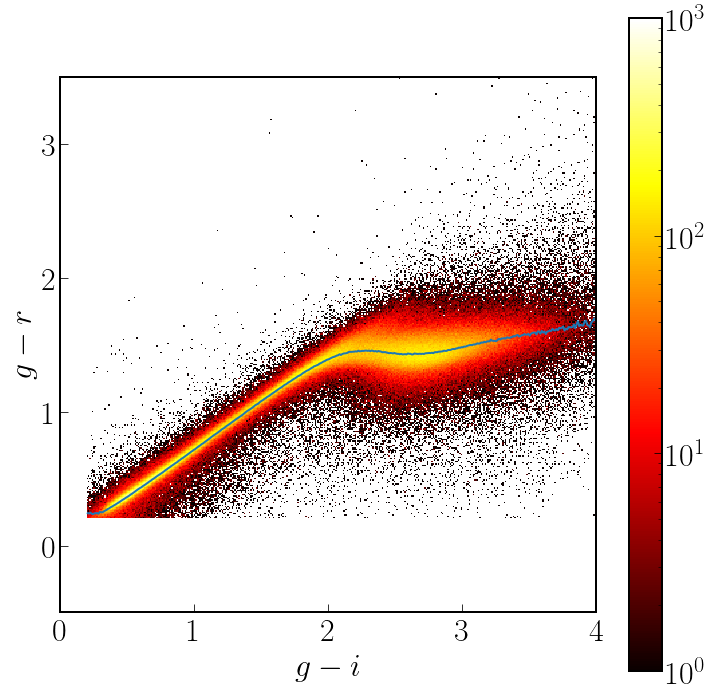

In [13]:
grgi(ms)

## clipping

In [8]:
def clip(t,x, y, xMin, xMax, Nbin, verbose=1): 
    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    tt=[]
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        t1 = t[(x>xEdge[i])&(x<=xEdge[i+1])]
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            t1=t1[(yAux<np.median(yAux)+3*sigmaG1)&(yAux>np.median(yAux)-3*sigmaG2)]
            tt.append(t1)
    tt=pd.concat(tt)
    return tt

In [9]:
tt=clip(ms,ms.gi,ms.gr, 0, 4, 400, 0)

In [10]:
len(tt)

555529

In [11]:
len(tt[tt.gr>1.8])/len(tt)

0.0047558273285463045

In [12]:
len(tt[tt.gi>3.8])/len(tt)

0.005697272329617356

In [13]:
mb=tt[(tt.gr<0.6)]#&(ms.gr>0.2)]
mr=tt[(tt.gr>0.6)]#&(ms.gr<1.6)]
len(tt),len(mb),len(mr)

(555529, 97087, 458442)

In [438]:
pwd='../Documents/final/newDCR2/'

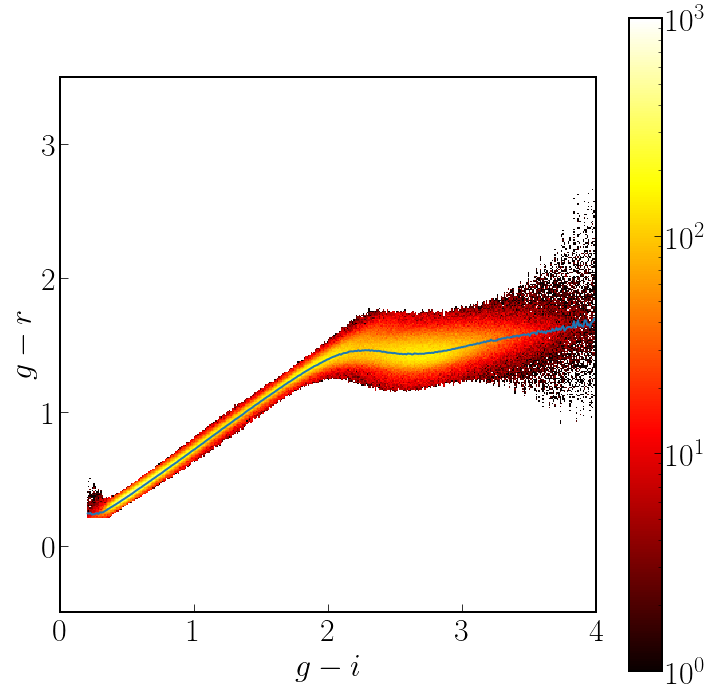

In [16]:
grgi(tt)
#plt.savefig(pwd+'clip.png')

In [440]:
tt['Dkpc'].loc[123741]=tt['Dkpc'].loc[123741]+0.1

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# pm vs d

## celestial coordinate R.A./Dec.

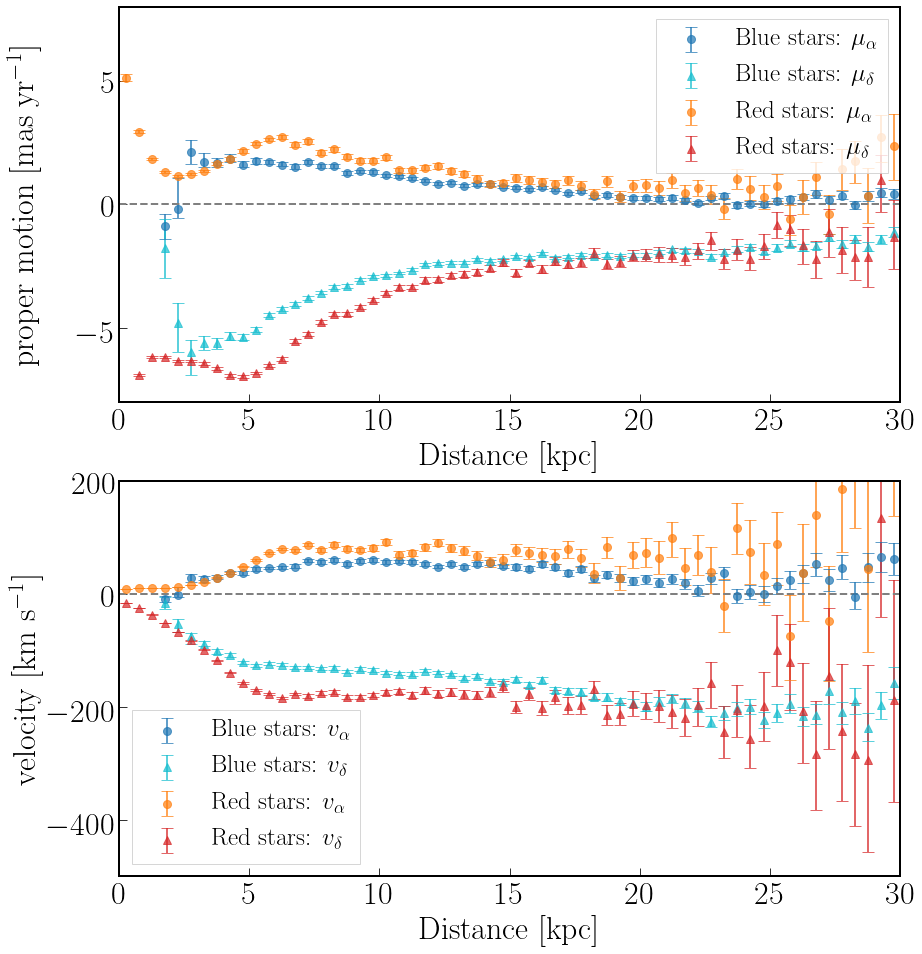

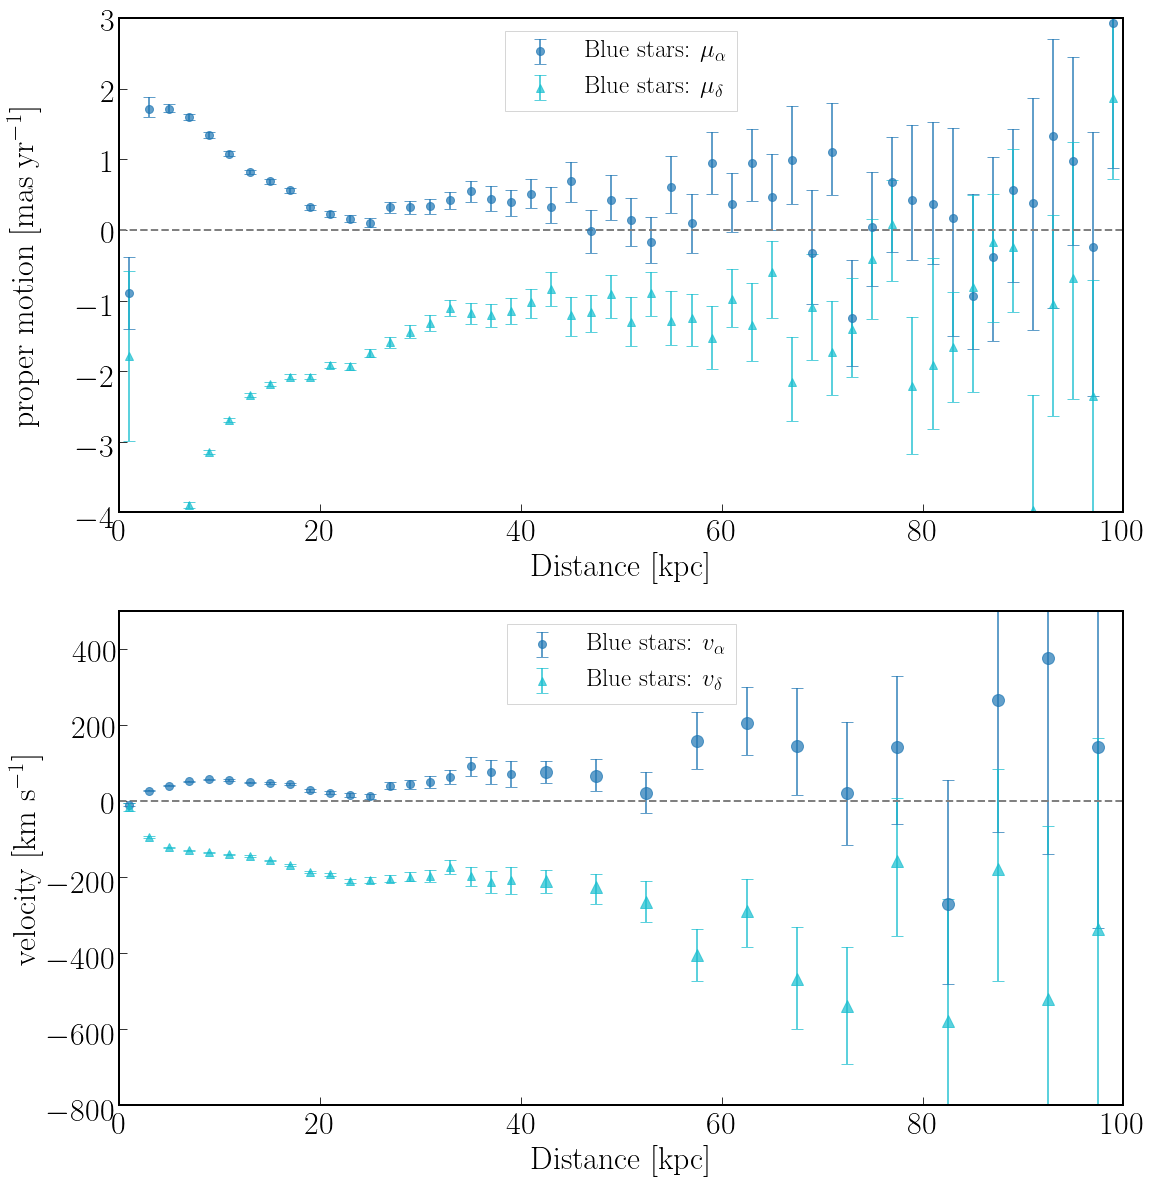

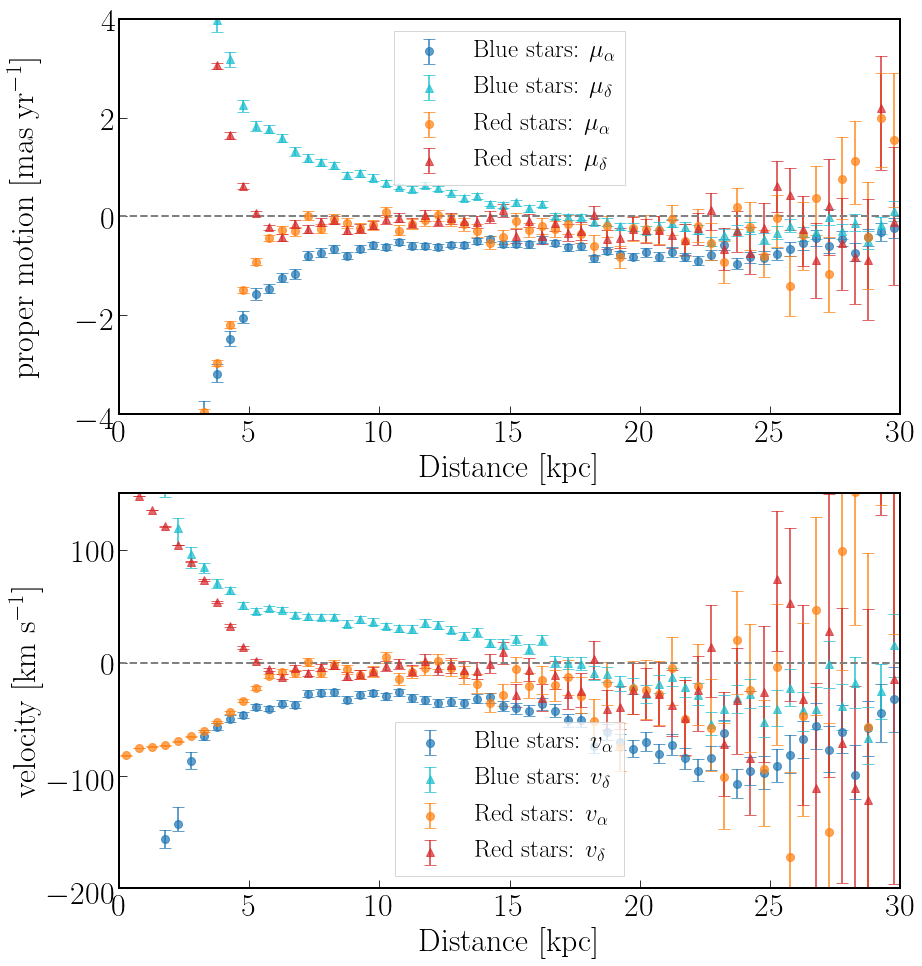

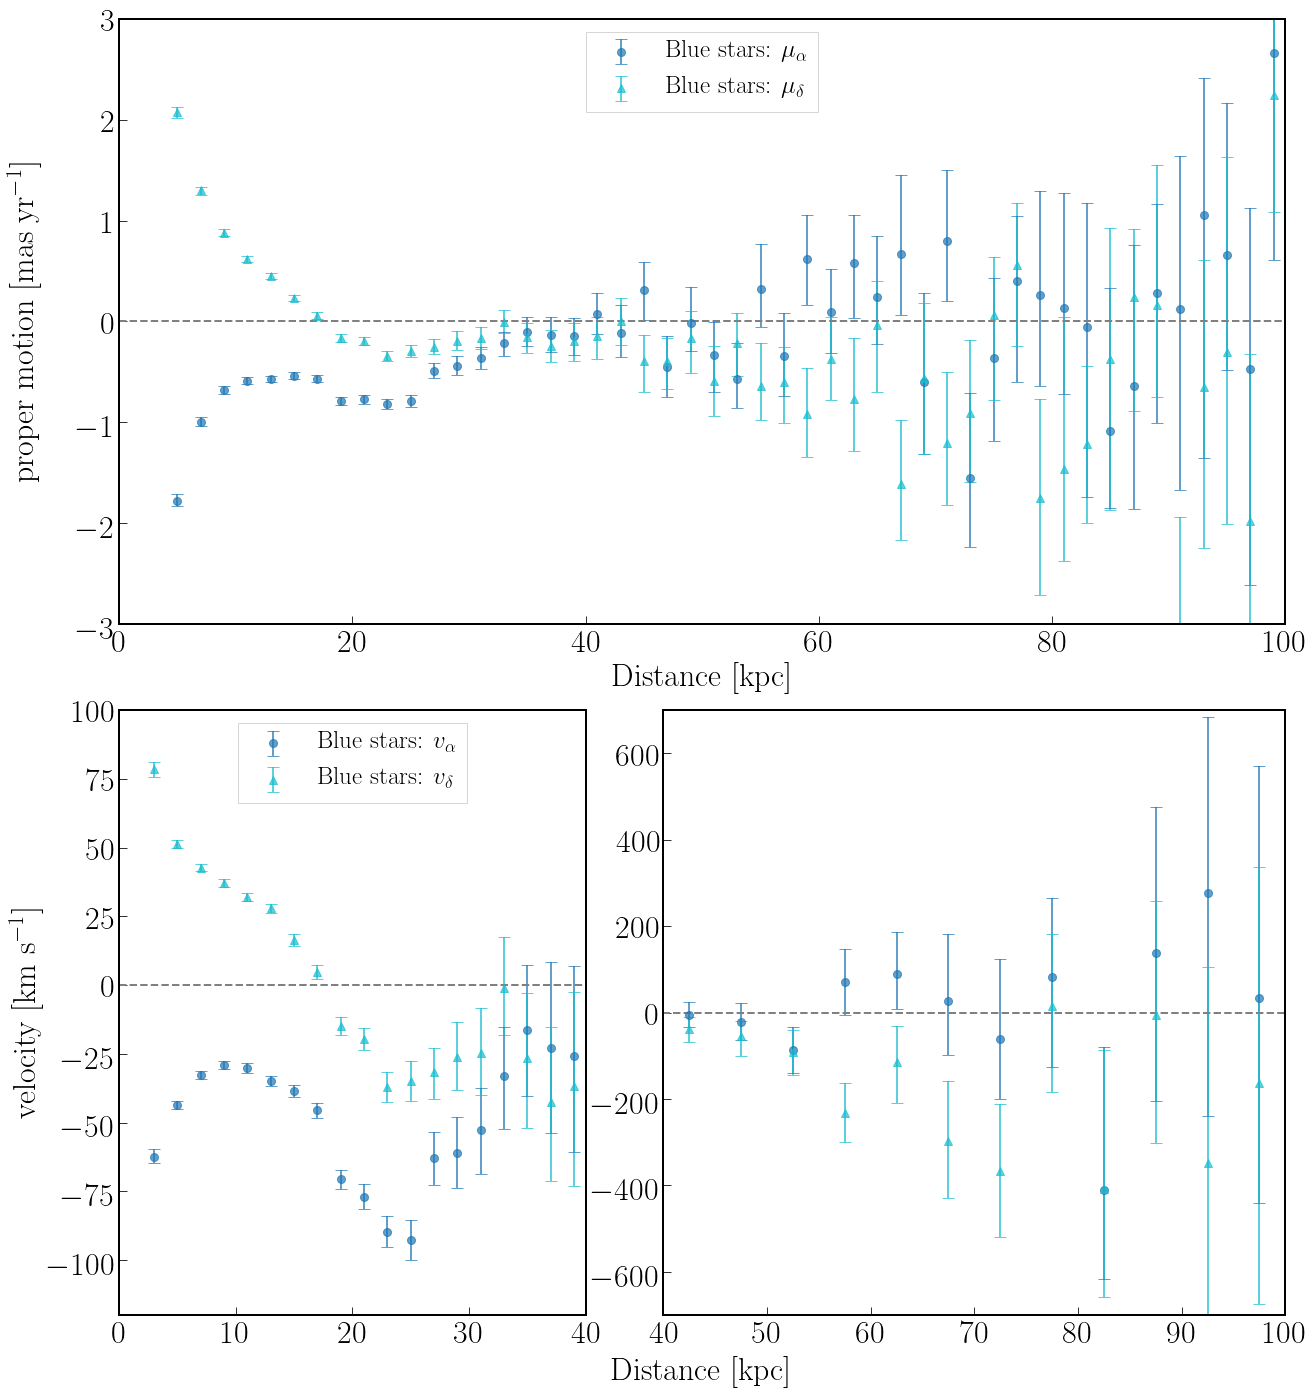

In [443]:
d_all()
dblue()
d_all_sm()
dblue_sm()

In [30]:
def dblue():
    r = mb.r_psfflux_mag
    gr = mb.gr
    D = mb.Dkpc
    vra = mb.v_ra
    vdec = mb.v_dec
    pmra = mb.pmra_cl3
    pmdec = mb.pmdec_cl3
    fig=plt.figure(figsize=(18,20))
    ax=plt.subplot(212)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,100)
    ax.set_ylim(-800,500)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin,fmt='o',c='tab:blue',capsize=6, markersize=8, alpha=0.7, label=r'Blue stars: $v_\alpha$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin,fmt='^',c='tab:cyan',capsize=6, markersize=8, alpha=0.7, label=r'Blue stars: $v_\delta$')
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 40, 100, 12, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 40, 100, 12, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('velocity vs. distance for blue stars')
    plt.legend(loc=9)



    ax=plt.subplot(211)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,100)
    ax.set_ylim(-4,3)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 100, 50, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 100, 50, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',c='tab:blue',capsize=6, markersize=8,alpha=0.7, label=r'Blue stars: $\mu_\alpha$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',c='tab:cyan',capsize=6, markersize=8,alpha=0.7, label=r'Blue stars: $\mu_\delta$')

    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend(loc=9)
    #plt.savefig('../Documents/final/1/dblue.pdf')
    plt.savefig(pwd+'dblue.pdf')

In [31]:
def d_all():
    t=[ms,mb,mr]
    c=['All','Blue','Red']
    color1=['darkblue','tab:blue','tab:orange']
    color2=['darkblue','tab:cyan','tab:red']
    fig=plt.figure(figsize=(14,16))
    ax = plt.subplot(212)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-500,200)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        r = t[i].r_psfflux_mag
        gr = t[i].gr
        D = t[i].Dkpc
        vra = t[i].v_ra
        vdec = t[i].v_dec
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, color=color1[i],fmt='o',capsize=6, markersize=8,alpha=0.7, label=c[i]+r' stars: $v_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, color=color2[i], fmt='^',capsize=6, markersize=8,alpha=0.7, label=c[i]+r' stars: $v_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00, c='grey',linestyle='dashed')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    ax = plt.subplot(211)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-8,8)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        r = t[i].r_psfflux_mag
        gr = t[i].gr
        D = t[i].Dkpc
        pmra = t[i].pmra_cl3
        pmdec = t[i].pmdec_cl3
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, color=color1[i],fmt='o',capsize=6, markersize=8,alpha=0.7, label=c[i]+r' stars: $\mu_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, color=color2[i],fmt='^',capsize=6, markersize=8,alpha=0.7, label=c[i]+r' stars: $\mu_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    #plt.savefig('../Documents/final/1/d_all.pdf')
    plt.savefig(pwd+'d_all.pdf')

In [32]:
def dblue_sm():
    r = mb.r_psfflux_mag
    gr = mb.gr
    D = mb.Dkpc
    vra = mb.v_ra_sm
    vdec = mb.v_dec_sm
    pmra = mb.pmra_cl_sm
    pmdec = mb.pmdec_cl_sm
    fig=plt.figure(figsize=(18,20))
#    ax=plt.subplot(212)
    ax=fig.add_axes([0.05,0.05,0.36,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-120,100)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
#    ax.set_xlabel('Distance [kpc]',fontsize=32)
    # binned medians to be more quantitative 
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x3Bin=x1Bin
#    m3edianBin=np.sqrt(m1edianBin**2+m2edianBin**2)
#    s3igGbin=(abs(m1edianBin)*s1igGbin+abs(m2edianBin)*s2igGbin)/m3edianBin
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:blue', alpha=0.7, label=r'Blue stars: $v_\alpha$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:cyan', alpha=0.7, label=r'Blue stars: $v_\delta$')
#    ax.errorbar(x3Bin, m3edianBin, s3igGbin, fmt='*',capsize=6, markersize=8,  c='grey', alpha=0.7, label=r'Blue stars: $|v|$')
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
    plt.legend(loc=9)
    
    ax=fig.add_axes([0.47,0.05,0.48,0.42])
    ax.set_xlim(40,100)
    ax.set_ylim(-700,700)
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 40, 100, 12, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 40, 100, 12, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:blue', alpha=0.7, label=r'Blue stars: $v_\alpha$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:cyan', alpha=0.7, label=r'Blue stars: $v_\delta$')
    ax.text(35,-850,'Distance [kpc]',fontsize=32)
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')




    #ax=plt.subplot(2,1,1)
    ax=fig.add_axes([0.05,0.53,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,100)
    ax.set_ylim(-3,3)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 100, 50, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 100, 50, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:blue', alpha=0.7, label=r'Blue stars: $\mu_\alpha$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:cyan', alpha=0.7, label=r'Blue stars: $\mu_\delta$')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 40, 100, 12, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 40, 100, 12, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 100, 150, 10, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 100, 150, 10, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8, alpha=0.7, c='tab:cyan')

    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend(loc=9)
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    plt.savefig(pwd+'dblue_sm.pdf')

In [33]:
def d_all_sm():
    t=[ms,mb,mr]
    c=['All','Blue','Red']
    color1=['darkblue','tab:blue','tab:orange']
    color2=['darkred','tab:cyan','tab:red']
    fig=plt.figure(figsize=(14,16))
    ax = plt.subplot(212)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-200,150)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        D = t[i].Dkpc
        vra = t[i].v_ra_sm
        vdec = t[i].v_dec_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i] ,capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i], capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    ax = plt.subplot(211)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-4,4)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        D = t[i].Dkpc
        pmra = t[i].pmra_cl_sm
        pmdec = t[i].pmdec_cl_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    #plt.savefig('../Documents/final/1/d_all_sm.pdf')
    plt.savefig(pwd+'d_all_sm.pdf')

## galactic coordinate l/b

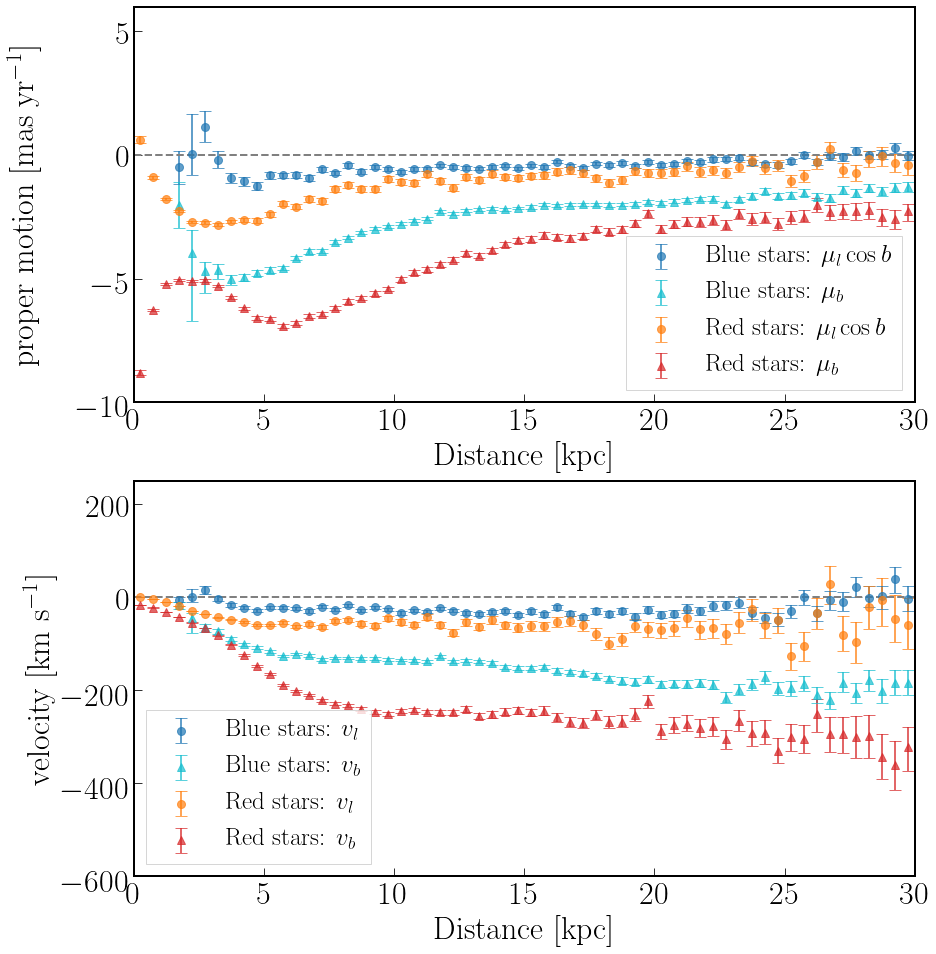

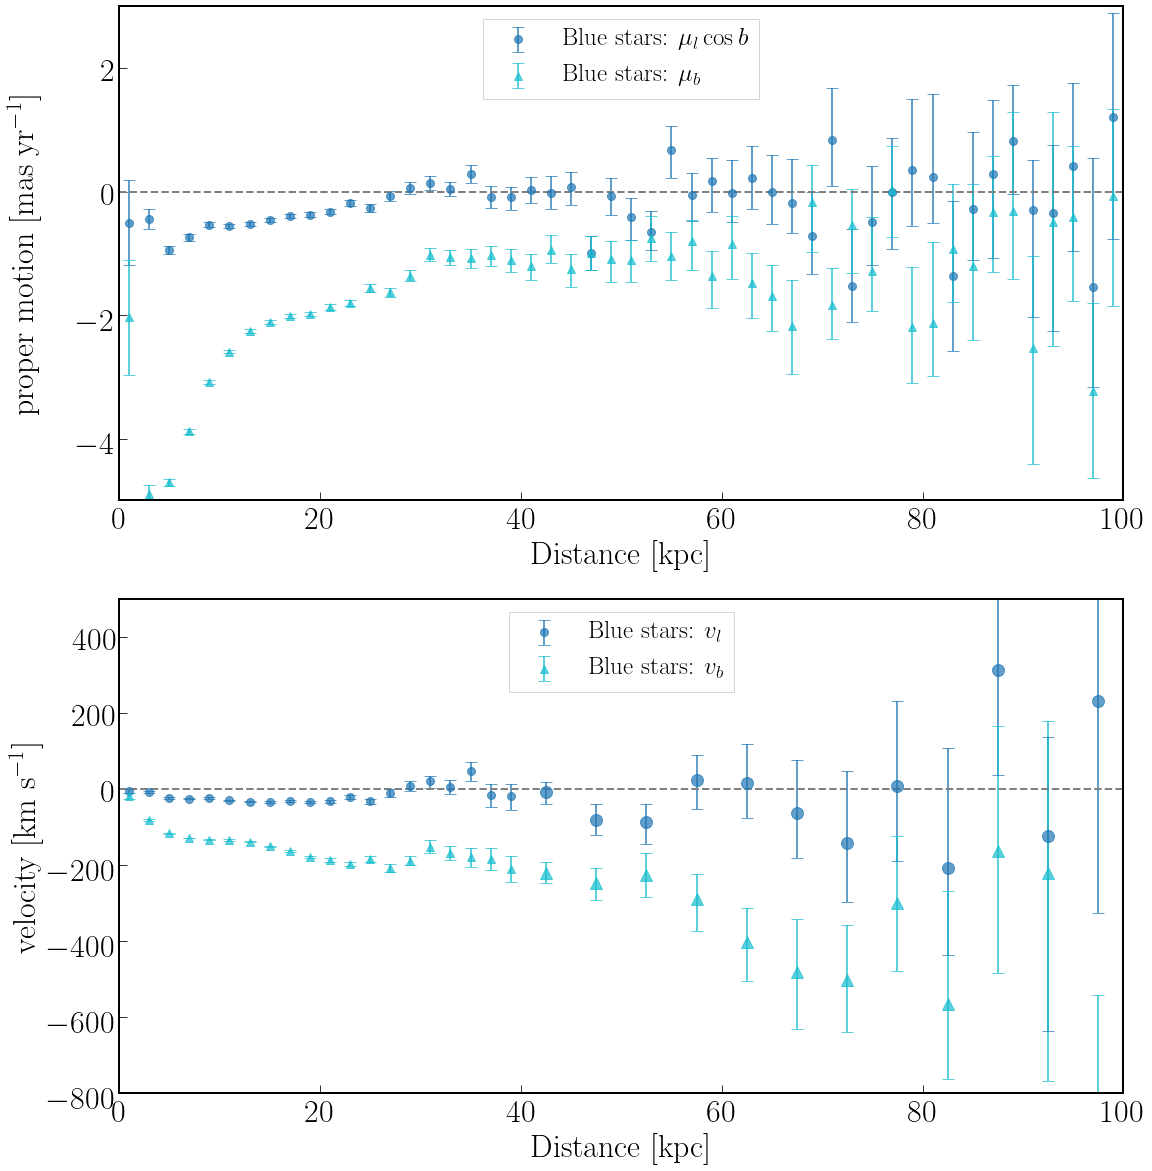

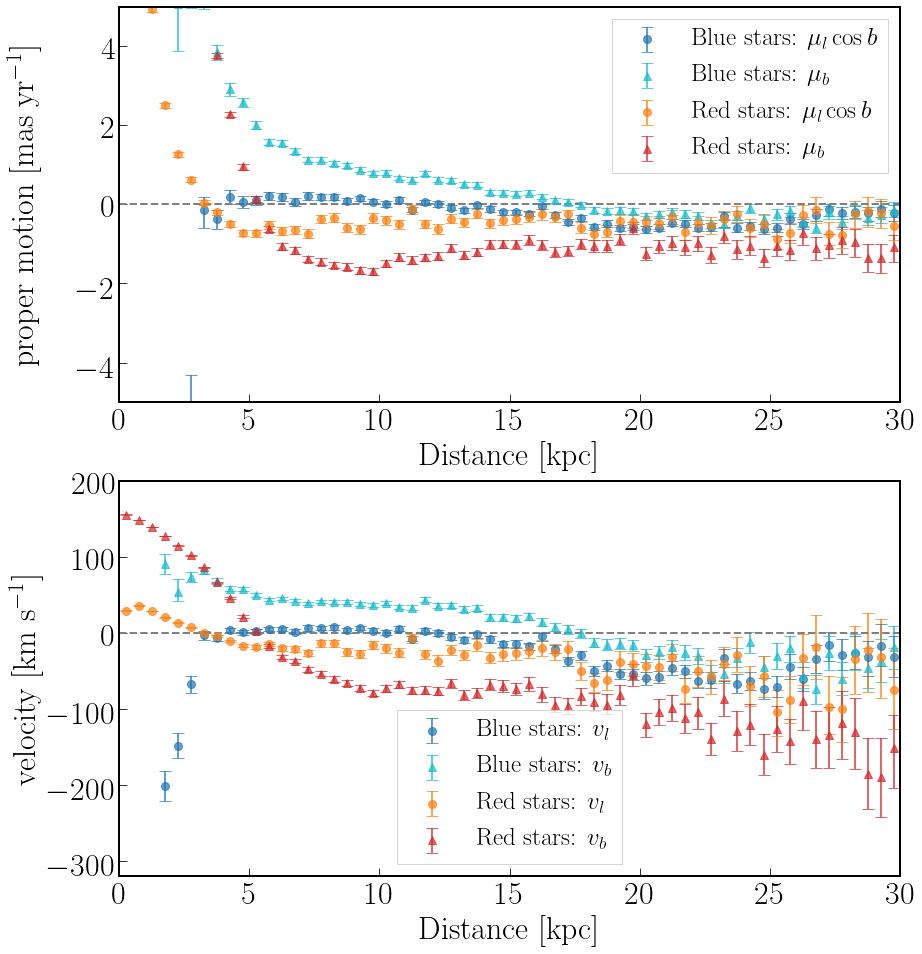

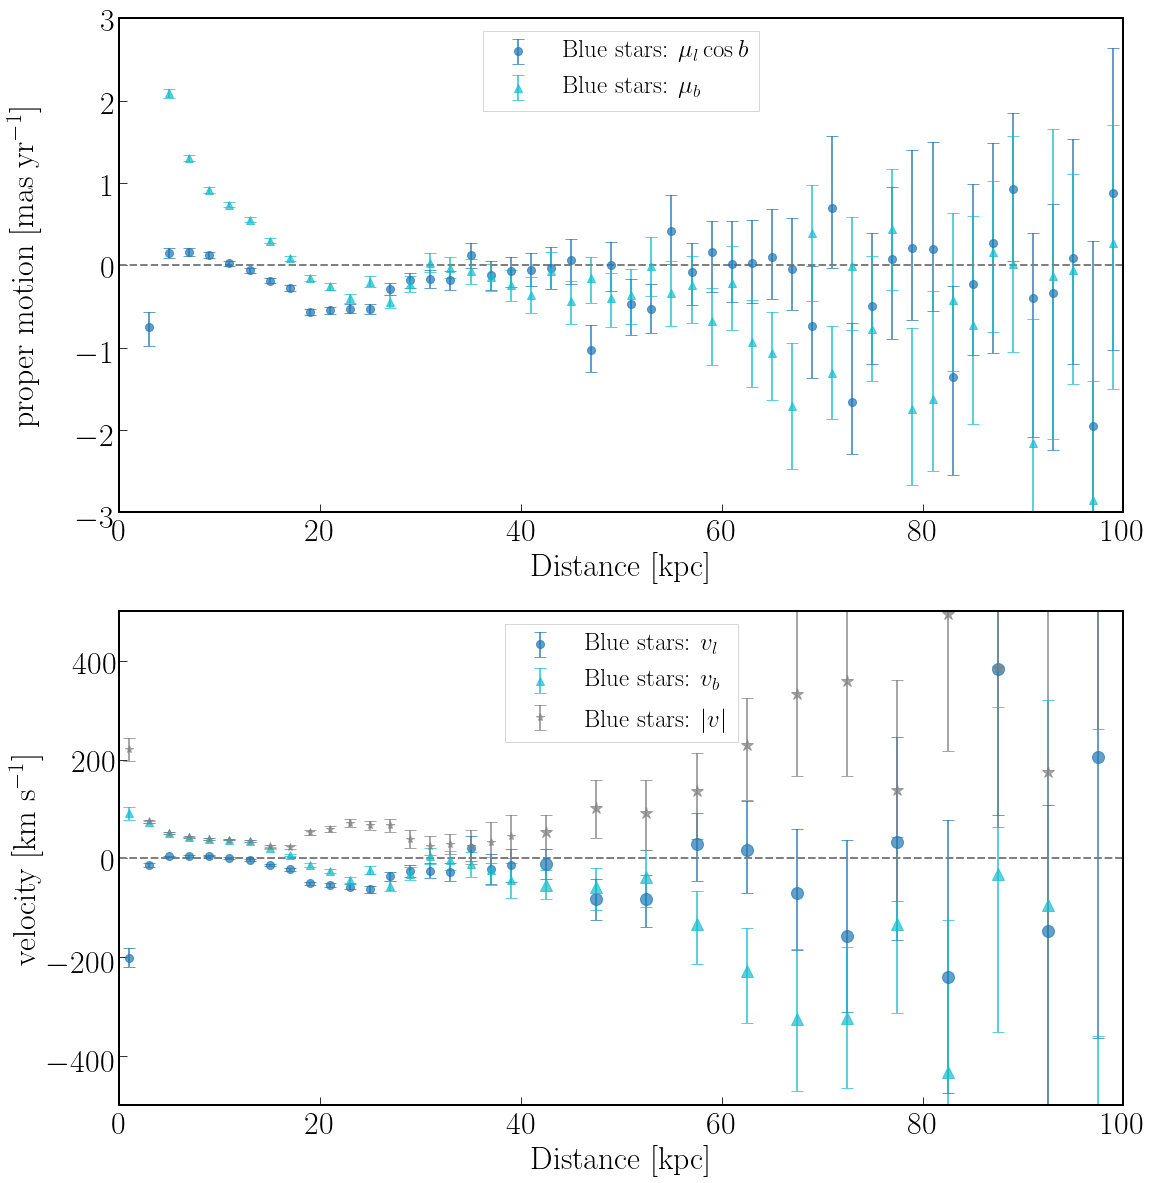

In [195]:
d_allbl()
dbluebl()
d_allbl_sm()
dbluebl_sm()

In [191]:
def dbluebl():
    r = mb.r_psfflux_mag
    gr = mb.gr
    D = mb.Dkpc
    vl = mb.v_lcosb
    vb = mb.v_b
    pml = mb.pm_lcosb
    pmb = mb.pm_b
    fig=plt.figure(figsize=(18,20))
    ax=plt.subplot(212)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,100)
    ax.set_ylim(-800,500)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vl, 0, 40, 20, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vb, 0, 40, 20, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin,fmt='o',c='tab:blue',capsize=6, markersize=8, alpha=0.7, label=r'Blue stars: $v_\ell$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin,fmt='^',c='tab:cyan',capsize=6, markersize=8, alpha=0.7, label=r'Blue stars: $v_b$')
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vl, 40, 100, 12, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vb, 40, 100, 12, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('velocity vs. distance for blue stars')
    plt.legend(loc=9)



    ax=plt.subplot(211)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,100)
    ax.set_ylim(-5,3)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pml, 0, 100, 50, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmb, 0, 100, 50, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',c='tab:blue',capsize=6, markersize=8,alpha=0.7, label=r'Blue stars: $\mu_l\cos b$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',c='tab:cyan',capsize=6, markersize=8,alpha=0.7, label=r'Blue stars: $\mu_b$')

    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend(loc=9)
    #plt.savefig('../Documents/final/1/dblue.pdf')
    plt.savefig(pwd+'dbluebl.pdf')

In [193]:
def d_allbl():
    t=[ms,mb,mr]
    c=['All','Blue','Red']
    color1=['darkblue','tab:blue','tab:orange']
    color2=['darkblue','tab:cyan','tab:red']
    fig=plt.figure(figsize=(14,16))
    ax = plt.subplot(212)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-600,250)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        r = t[i].r_psfflux_mag
        gr = t[i].gr
        D = t[i].Dkpc
        vl = t[i].v_lcosb
        vb = t[i].v_b
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vl, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vb, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, color=color1[i],fmt='o',capsize=6, markersize=8,alpha=0.7, label=c[i]+r' stars: $v_l$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, color=color2[i], fmt='^',capsize=6, markersize=8,alpha=0.7, label=c[i]+r' stars: $v_b$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00, c='grey',linestyle='dashed')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    ax = plt.subplot(211)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-10,6)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        r = t[i].r_psfflux_mag
        gr = t[i].gr
        D = t[i].Dkpc
        pml = t[i].pm_lcosb
        pmb = t[i].pm_b
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pml, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmb, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, color=color1[i],fmt='o',capsize=6, markersize=8,alpha=0.7, label=c[i]+r' stars: $\mu_l\cos b$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, color=color2[i],fmt='^',capsize=6, markersize=8,alpha=0.7, label=c[i]+r' stars: $\mu_b$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    #plt.savefig('../Documents/final/1/d_all.pdf')
    plt.savefig(pwd+'d_allbl.pdf')

In [192]:
def d_allbl_sm():
    t=[ms,mb,mr]
    c=['All','Blue','Red']
    color1=['darkblue','tab:blue','tab:orange']
    color2=['darkred','tab:cyan','tab:red']
    fig=plt.figure(figsize=(14,16))
    ax = plt.subplot(212)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-320,200)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        r = t[i].r_psfflux_mag
        gr = t[i].gr
        D = t[i].Dkpc
        vl = t[i].v_lcosb_sm
        vb = t[i].v_b_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vl, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vb, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i] ,capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_l$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i], capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_b$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    ax = plt.subplot(211)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-5,5)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        r = t[i].r_psfflux_mag
        gr = t[i].gr
        D = t[i].Dkpc
        pml = t[i].pm_lcosb_sm
        pmb = t[i].pm_b_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pml, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmb, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_l\cos b$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_b$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    #plt.savefig('../Documents/final/1/d_all_sm.pdf')
    plt.savefig(pwd+'d_allbl_sm.pdf')

In [301]:
def dbluebl_sm():
    r = mb.r_psfflux_mag
    gr = mb.gr
    D = mb.Dkpc
    vl = mb.v_lcosb_sm
    vb = mb.v_b_sm
    pml = mb.pm_lcosb_sm
    pmb = mb.pm_b_sm
    fig=plt.figure(figsize=(18,20))
#    ax=plt.subplot(212)
    ax=fig.add_axes([0.05,0.05,0.36,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-100,100)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
#    ax.set_xlabel('Distance [kpc]',fontsize=32)
    # binned medians to be more quantitative 
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vl, 0, 40, 20, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vb, 0, 40, 20, 0)
    x3Bin=x1Bin
    m3edianBin=np.sqrt(m1edianBin**2+m2edianBin**2)
    s3igGbin=(abs(m1edianBin)*s1igGbin+abs(m2edianBin)*s2igGbin)/m3edianBin
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:blue', alpha=0.7, label=r'Blue stars: $v_l$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:cyan', alpha=0.7, label=r'Blue stars: $v_b$')
    ax.errorbar(x3Bin, m3edianBin, s3igGbin, fmt='*',capsize=6, markersize=8,  c='grey', alpha=0.7, label=r'Blue stars: $|v|$')
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
    plt.legend()

    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    #ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax=fig.add_axes([0.47,0.05,0.48,0.42])
    ax.set_xlim(40,100)
    ax.set_ylim(-700,700)
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vl, 40, 100, 12, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vb, 40, 100, 12, 0)
    x3Bin=x1Bin
    m3edianBin=np.sqrt(m1edianBin**2+m2edianBin**2)
    s3igGbin=(abs(m1edianBin)*s1igGbin+abs(m2edianBin)*s2igGbin)/m3edianBin
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
    ax.errorbar(x3Bin, m3edianBin, s3igGbin, fmt='*',capsize=6, markersize=12,  c='grey', alpha=0.7, label=r'Blue stars: $|v|$')
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    ax.text(35,-850,'Distance [kpc]',fontsize=32)




#    ax=plt.subplot(2,1,1)
    ax=fig.add_axes([0.05,0.53,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,100)
    ax.set_ylim(-3,3)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pml, 0, 100, 50, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmb, 0, 100, 50, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:blue', alpha=0.7, label=r'Blue stars: $\mu_l\cos b$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:cyan', alpha=0.7, label=r'Blue stars: $\mu_b$')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 40, 100, 12, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 40, 100, 12, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 100, 150, 10, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 100, 150, 10, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8, alpha=0.7, c='tab:cyan')

    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend(loc=9)
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    plt.savefig(pwd+'dbluebl_sm.pdf')

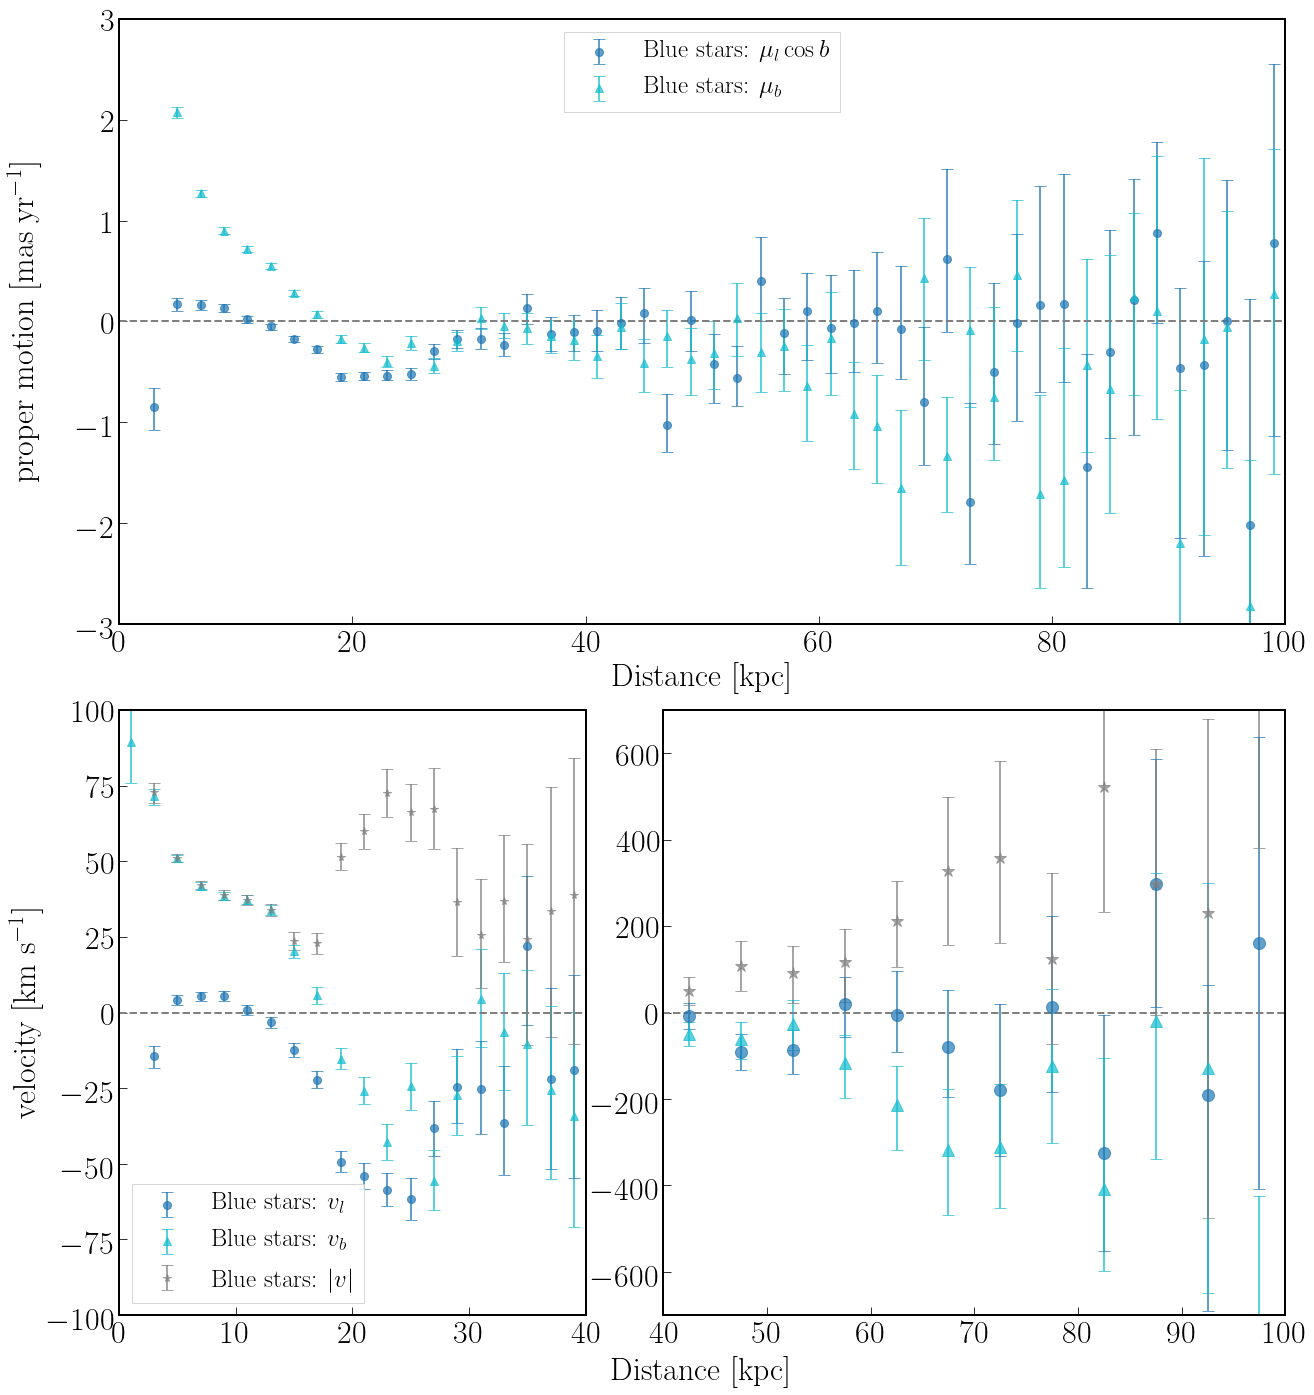

In [302]:
dbluebl_sm()

In [14]:
np.median(mb.psfMag_g-mb.g_psfflux_mag),np.median(mb.psfMag_r-mb.r_psfflux_mag),np.median(mb.psfMag_i-mb.i_psfflux_mag)

(0.025389800000002793, 0.003903399999998669, -0.012594199999998779)

In [15]:
np.median(mr.psfMag_g-mr.g_psfflux_mag),np.median(mr.psfMag_r-mr.r_psfflux_mag),np.median(mr.psfMag_i-mr.i_psfflux_mag)

(0.13686235000000124, 0.011165650000000582, 0.08586479999999952)

In [242]:
np.median(mr.gc-mr.psfMag_g),np.median(mr.rc-mr.psfMag_r),np.median(mr.ic-mr.psfMag_i)

(-0.01665246219011607, -0.0019259263478890176, -0.00266921048435087)

In [243]:
np.median(mb.gc-mb.psfMag_g),np.median(mb.rc-mb.psfMag_r),np.median(mb.ic-mb.psfMag_i)

(-0.0008464859099603927, 0.003262917257892184, 0.00530270389420906)

# over 40kpc 

In [68]:
def sig1(a):
    s=(0.741*(np.percentile(a,75)-np.percentile(a,50)))*2
    e=np.sqrt(np.pi/2)*s/np.sqrt(len(a))
    return e
def sig2(a):
    s=(0.741*(np.percentile(a,50)-np.percentile(a,25)))*2
    e=np.sqrt(np.pi/2)*s/np.sqrt(len(a))
    return e

In [168]:
len(mb[mb.Dkpc>40])

7343

In [190]:
tb=mb[mb.Dkpc>40]

In [191]:
np.median(tb.pmra_cl_sm),sig1(tb.pmra_cl_sm),sig2(tb.pmra_cl_sm)

(-0.09074845943697664, 0.08981342751726885, 0.08556707798299548)

In [192]:
np.median(tb.pmdec_cl_sm),sig1(tb.pmdec_cl_sm),sig2(tb.pmdec_cl_sm)

(-0.3976873423745558, 0.07864161606590539, 0.0869314543643213)

In [172]:
np.median(tb.v_ra_sm),sig1(tb.v_ra_sm),sig2(tb.v_ra_sm)

(-20.633558445050788, 23.21875703426259, 22.245054635769876)

In [173]:
np.median(tb.v_dec_sm),sig1(tb.v_dec_sm),sig2(tb.v_dec_sm)

(-97.06653736187477, 19.891580049317675, 23.301119247927698)

In [174]:
np.median(tb.pm_b_sm),sig1(tb.pm_b_sm),sig2(tb.pm_b_sm)

(-0.3551889126378997, 0.08134534765430719, 0.09036381321637123)

In [175]:
np.median(tb.pm_lcosb_sm),sig1(tb.pm_lcosb_sm),sig2(tb.pm_lcosb_sm)

(-0.16664716190739695, 0.08333257644919849, 0.08665193889949988)

In [176]:
np.median(tb.v_b_sm),sig1(tb.v_b_sm),sig2(tb.v_b_sm)

(-87.30962395560941, 20.94142963059987, 24.362419174707814)

In [177]:
np.median(tb.v_lcosb_sm),sig1(tb.v_lcosb_sm),sig2(tb.v_lcosb_sm)

(-42.249957779675505, 21.50910415613055, 22.452643033571825)

# velocity in each bins 

## pm/velocity difference between before and after solar motion subtracting

In [444]:
v=[]#mr/mb vra/vdec before/after
t=[mr,mb]
for i in range(2):
    D = t[i].Dkpc
    vra = t[i].pmra_cl3
    vdec = t[i].pmdec_cl3
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 30, 60, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 30, 60, 0)
    v.append(m1edianBin)
    v.append(m2edianBin)
    D = t[i].Dkpc
    vra = t[i].pmra_cl_sm
    vdec = t[i].pmdec_cl_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 30, 60, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 30, 60, 0)
    v.append(m1edianBin)
    v.append(m2edianBin)

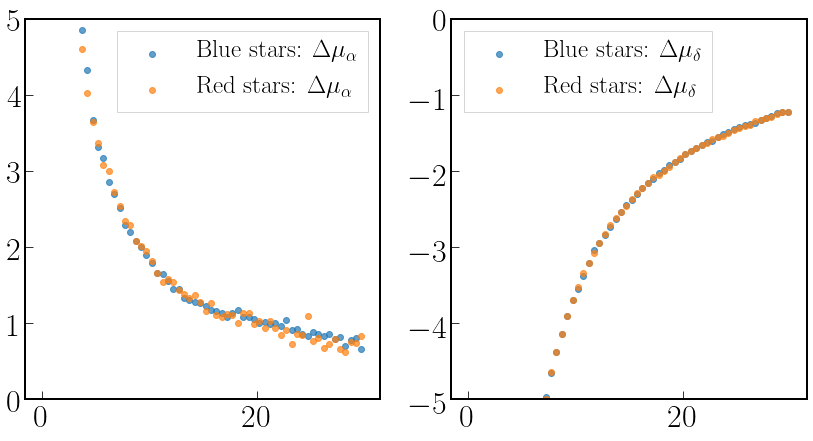

In [445]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.scatter(x1Bin,v[4]-v[6],alpha=0.7,label=r'Blue stars: $\Delta \mu_\alpha$')
plt.scatter(x1Bin,v[0]-v[2],alpha=0.7,label=r'Red stars: $\Delta \mu_\alpha$')
plt.legend()
plt.ylim(0,5)
plt.subplot(122)
plt.scatter(x1Bin,v[5]-v[7],alpha=0.7,label=r'Blue stars: $\Delta \mu_\delta$')
plt.scatter(x1Bin,v[1]-v[3],alpha=0.7,label=r'Red stars: $\Delta \mu_\delta$')
plt.legend()
plt.ylim(-5,0)
'''
plt.subplot(223)
plt.scatter(x1Bin,v[0]-v[2],label=r'Red stars: $\Delta \mu_\alpha$')
plt.scatter(x1Bin,v[4]-v[6],label=r'Blue stars: $\Delta \mu_\alpha$')
plt.legend()
plt.subplot(224)
plt.scatter(x1Bin,v[0]-v[2],label=r'Red stars: $\Delta \mu_\alpha$')
plt.scatter(x1Bin,v[4]-v[6],label=r'Blue stars: $\Delta \mu_\alpha$')
plt.legend()'''
plt.savefig('../Documents/final/solar_motion_test/Delta_pm_subtracting.pdf')

In [446]:
v=[]#mr/mb vra/vdec before/after
t=[mr,mb]
for i in range(2):
    D = t[i].Dkpc
    vra = t[i].v_ra
    vdec = t[i].v_dec
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 30, 60, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 30, 60, 0)
    v.append(m1edianBin)
    v.append(m2edianBin)
    D = t[i].Dkpc
    vra = t[i].v_ra_sm
    vdec = t[i].v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 30, 60, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 30, 60, 0)
    v.append(m1edianBin)
    v.append(m2edianBin)

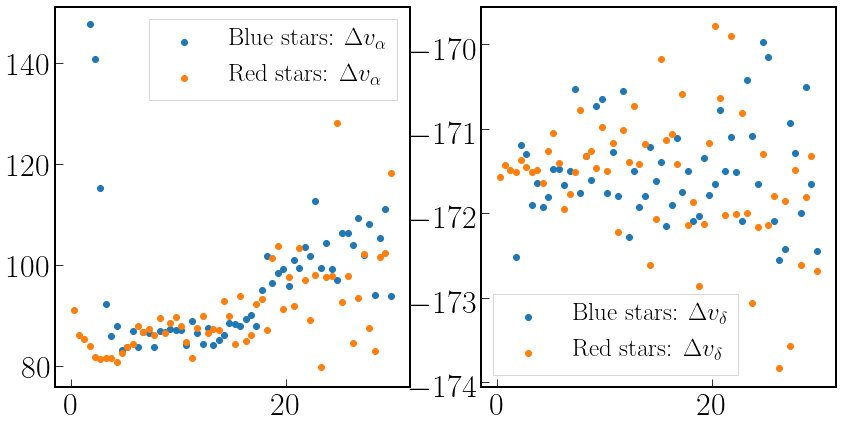

In [447]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.scatter(x1Bin,v[4]-v[6],label=r'Blue stars: $\Delta v_\alpha$')
plt.scatter(x1Bin,v[0]-v[2],label=r'Red stars: $\Delta v_\alpha$')
plt.legend()
plt.subplot(122)
plt.scatter(x1Bin,v[5]-v[7],label=r'Blue stars: $\Delta v_\delta$')
plt.scatter(x1Bin,v[1]-v[3],label=r'Red stars: $\Delta v_\delta$')
plt.legend()
'''
plt.subplot(223)
plt.scatter(x1Bin,v[0]-v[2],label=r'Red stars: $\Delta v_\alpha$')
plt.scatter(x1Bin,v[4]-v[6],label=r'Blue stars: $\Delta v_\alpha$')
plt.legend()
plt.subplot(224)
plt.scatter(x1Bin,v[0]-v[2],label=r'Red stars: $\Delta v_\alpha$')
plt.scatter(x1Bin,v[4]-v[6],label=r'Blue stars: $\Delta v_\alpha$')
plt.legend()'''
plt.savefig('../Documents/final/solar_motion_test/Delta_v_subtracting.pdf')

# Sgr

In [39]:
mb0=mb[mb.i_sdsscentroid_ra<-15]
mb1=mb[(mb.i_sdsscentroid_ra>-15)&(mb.i_sdsscentroid_ra<10)]
mb2=mb[(mb.i_sdsscentroid_ra>10)&(mb.i_sdsscentroid_ra<25)]
mb3=mb[(mb.i_sdsscentroid_ra>25)]

In [326]:
mr0=mr[mr.i_sdsscentroid_ra<-15]
mr1=mr[(mr.i_sdsscentroid_ra>-15)&(mr.i_sdsscentroid_ra<10)]
mr2=mr[(mr.i_sdsscentroid_ra>10)&(mr.i_sdsscentroid_ra<25)]
mr3=mr[(mr.i_sdsscentroid_ra>25)]

In [11]:
ms0=tt[tt.i_sdsscentroid_ra<-15]
ms1=tt[(tt.i_sdsscentroid_ra>-15)&(tt.i_sdsscentroid_ra<10)]
ms2=tt[(tt.i_sdsscentroid_ra>10)&(tt.i_sdsscentroid_ra<25)]
ms3=tt[(tt.i_sdsscentroid_ra>25)]

In [194]:
len(mb0),len(mb1),len(mb2),len(mb3)

(43789, 35745, 12484, 5069)

In [327]:
len(mr0),len(mr1),len(mr2),len(mr3)

(238983, 172538, 36156, 10765)

In [210]:
min(mb3.i_sdsscentroid_ra),max(mb3.i_sdsscentroid_ra)

(28.680908784431853, 35.889792580084034)

## in different R.A. bins

In [323]:
def sgrb():
    fig=plt.figure(figsize=(18,32))
    
    #ax=plt.subplot(4,1,1)
    ax=fig.add_axes([0.05,0.83,0.9,0.145])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-4,1)
    ax.set_xticks([5,10,15,20,25,30,35])
#    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_yticks([-3,-2,-1,0])
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    D = mb0.Dkpc
    pmra = mb0.pmra_cl_sm
 #   pmdec = mb0.pmdec_cl_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, markerfacecolor='white', alpha=0.7, label='R.A. $[-30,-15]$')
#    ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\delta$')
 
    D = mb1.Dkpc
    pmra = mb1.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, markerfacecolor='white',alpha=0.7, label='R.A. $[-15, 4]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = mb2.Dkpc
    pmra = mb2.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label='R.A. $[15, 23]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = mb3.Dkpc
    pmra = mb3.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,alpha=0.7, label='R.A. $[28, 36]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    

    ax.text(15,0.2,r'Blue stars: $\mu_\alpha$',fontsize=32)

    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend()
    
    #ax=plt.subplot(412)
    ax=fig.add_axes([0.05,0.685,0.9,0.145])
    ax.set_xlim(0,40)
    ax.set_ylim(-2,3)
    ax.set_xticks([5,10,15,20,25,30,35])
#    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_yticks([-1,0,1,2])
#    ax.set_xticks([])
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    D = mb0.Dkpc
    pmdec = mb0.pmdec_cl_sm
 #   pmdec = mb0.pmdec_cl_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  alpha=0.7, markerfacecolor='white',label='R.A. $[-30,-15]$')
#    ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\delta$')
 
    D = mb1.Dkpc
    pmdec = mb1.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7,markerfacecolor='white', label='R.A. $[-15, 4]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = mb2.Dkpc
    pmdec = mb2.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label='R.A. $[15, 23]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = mb3.Dkpc
    pmdec = mb3.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,alpha=0.7, label='R.A. $[28, 36]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    

    ax.text(15,2.2,r'Blue stars: $\mu_\delta$',fontsize=32)

    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
#    plt.legend()
    #
#    ax=plt.subplot(413)
    ax=fig.add_axes([0.05,0.54,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-400,100)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)  
    ax.set_xticks([5,10,15,20,25,30,35])
    #ax.set_xlabel('Distance [kpc]',fontsize=32)
    # binned medians to be more quantitative 
    ax.set_yticks([-300,-200,-100,0])
#    ax.set_xticks([])
    D = mb0.Dkpc
    vra = mb0.v_ra_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',alpha=0.7, label=r'Blue stars within R.A. $[-30,-15]$: $v_\alpha$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = mb1.Dkpc
    vra = mb1.v_ra_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',  alpha=0.7, label=r'Blue stars within R.A. $[-15,4]$: $v_\alpha$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mb2.Dkpc
    vra = mb2.v_ra_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. $[15,23]$: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mb3.Dkpc
    vra = mb3.v_ra_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. $[28,36]$: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,20,r'Blue stars: $v_\alpha$',fontsize=32)
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')




#    ax=plt.subplot(414)
    ax=fig.add_axes([0.05,0.395,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
#    ax.set_xticks([5,10,15,20,25,30,35])
    ax.set_yticks([-200,-100,0,100])
#    ax.set_xticks([])    
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = mb0.Dkpc
    vdec = mb0.v_dec_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7,  markerfacecolor='white',label=r'Blue stars within R.A. $[-30,-15]$: $v_\alpha$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = mb1.Dkpc
    vdec = mb1.v_dec_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  alpha=0.7,  markerfacecolor='white',label=r'Blue stars within R.A. $[-15,4]$: $v_\alpha$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mb2.Dkpc
    vdec = mb2.v_dec_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. $[15,23$]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mb3.Dkpc
    vdec = mb3.v_dec_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [28,36]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,120,r'Blue stars: $v_\delta$',fontsize=32)
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)

    ax.set_xlabel('Distance [kpc]',fontsize=32)

    ax=fig.add_axes([0.05,0.205,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
    ax.set_xticks([5,10,15,20,25,30,35])    
#    ax.set_xticks([5,10,15,20,25,30,35])
    
#    ax.set_xticks([])
#    ax.set_yticks([-200,-100,0,100])
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = mb0.Dkpc
    vdec = mb0.v_lcosb_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white' ,alpha=0.7, label=r'R.A. $[-30,-15]$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = mb1.Dkpc
    vdec = mb1.v_lcosb_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',  alpha=0.7, label=r'R.A. $[-15,4]$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mb2.Dkpc
    vdec = mb2.v_lcosb_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [15,23]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mb3.Dkpc
    vdec = mb3.v_lcosb_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [28,36]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,120,r'Blue stars: $v_\ell$',fontsize=32)
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)
    ax=fig.add_axes([0.05,0.06,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
    ax.set_yticks([-200,-100,0,100])

    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = mb0.Dkpc
    vdec = mb0.v_b_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white', alpha=0.7, label=r'R.A. $[-30,-15]$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = mb1.Dkpc
    vdec = mb1.v_b_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white' , alpha=0.7, label=r'R.A. $[-15,4]$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mb2.Dkpc
    vdec = mb2.v_b_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'R.A. $[15,23]$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mb3.Dkpc
    vdec = mb3.v_b_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'R.A. $[28,36]$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,120,r'Blue stars: $v_b$',fontsize=32)
#    plt.legend()
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)

    
    ax.set_xlabel('Distance [kpc]',fontsize=32)

    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
#    plt.savefig(pwd+'dblue_sm_sagibl.pdf')
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    plt.savefig(pwd+'dblue_sm_sagi.pdf')

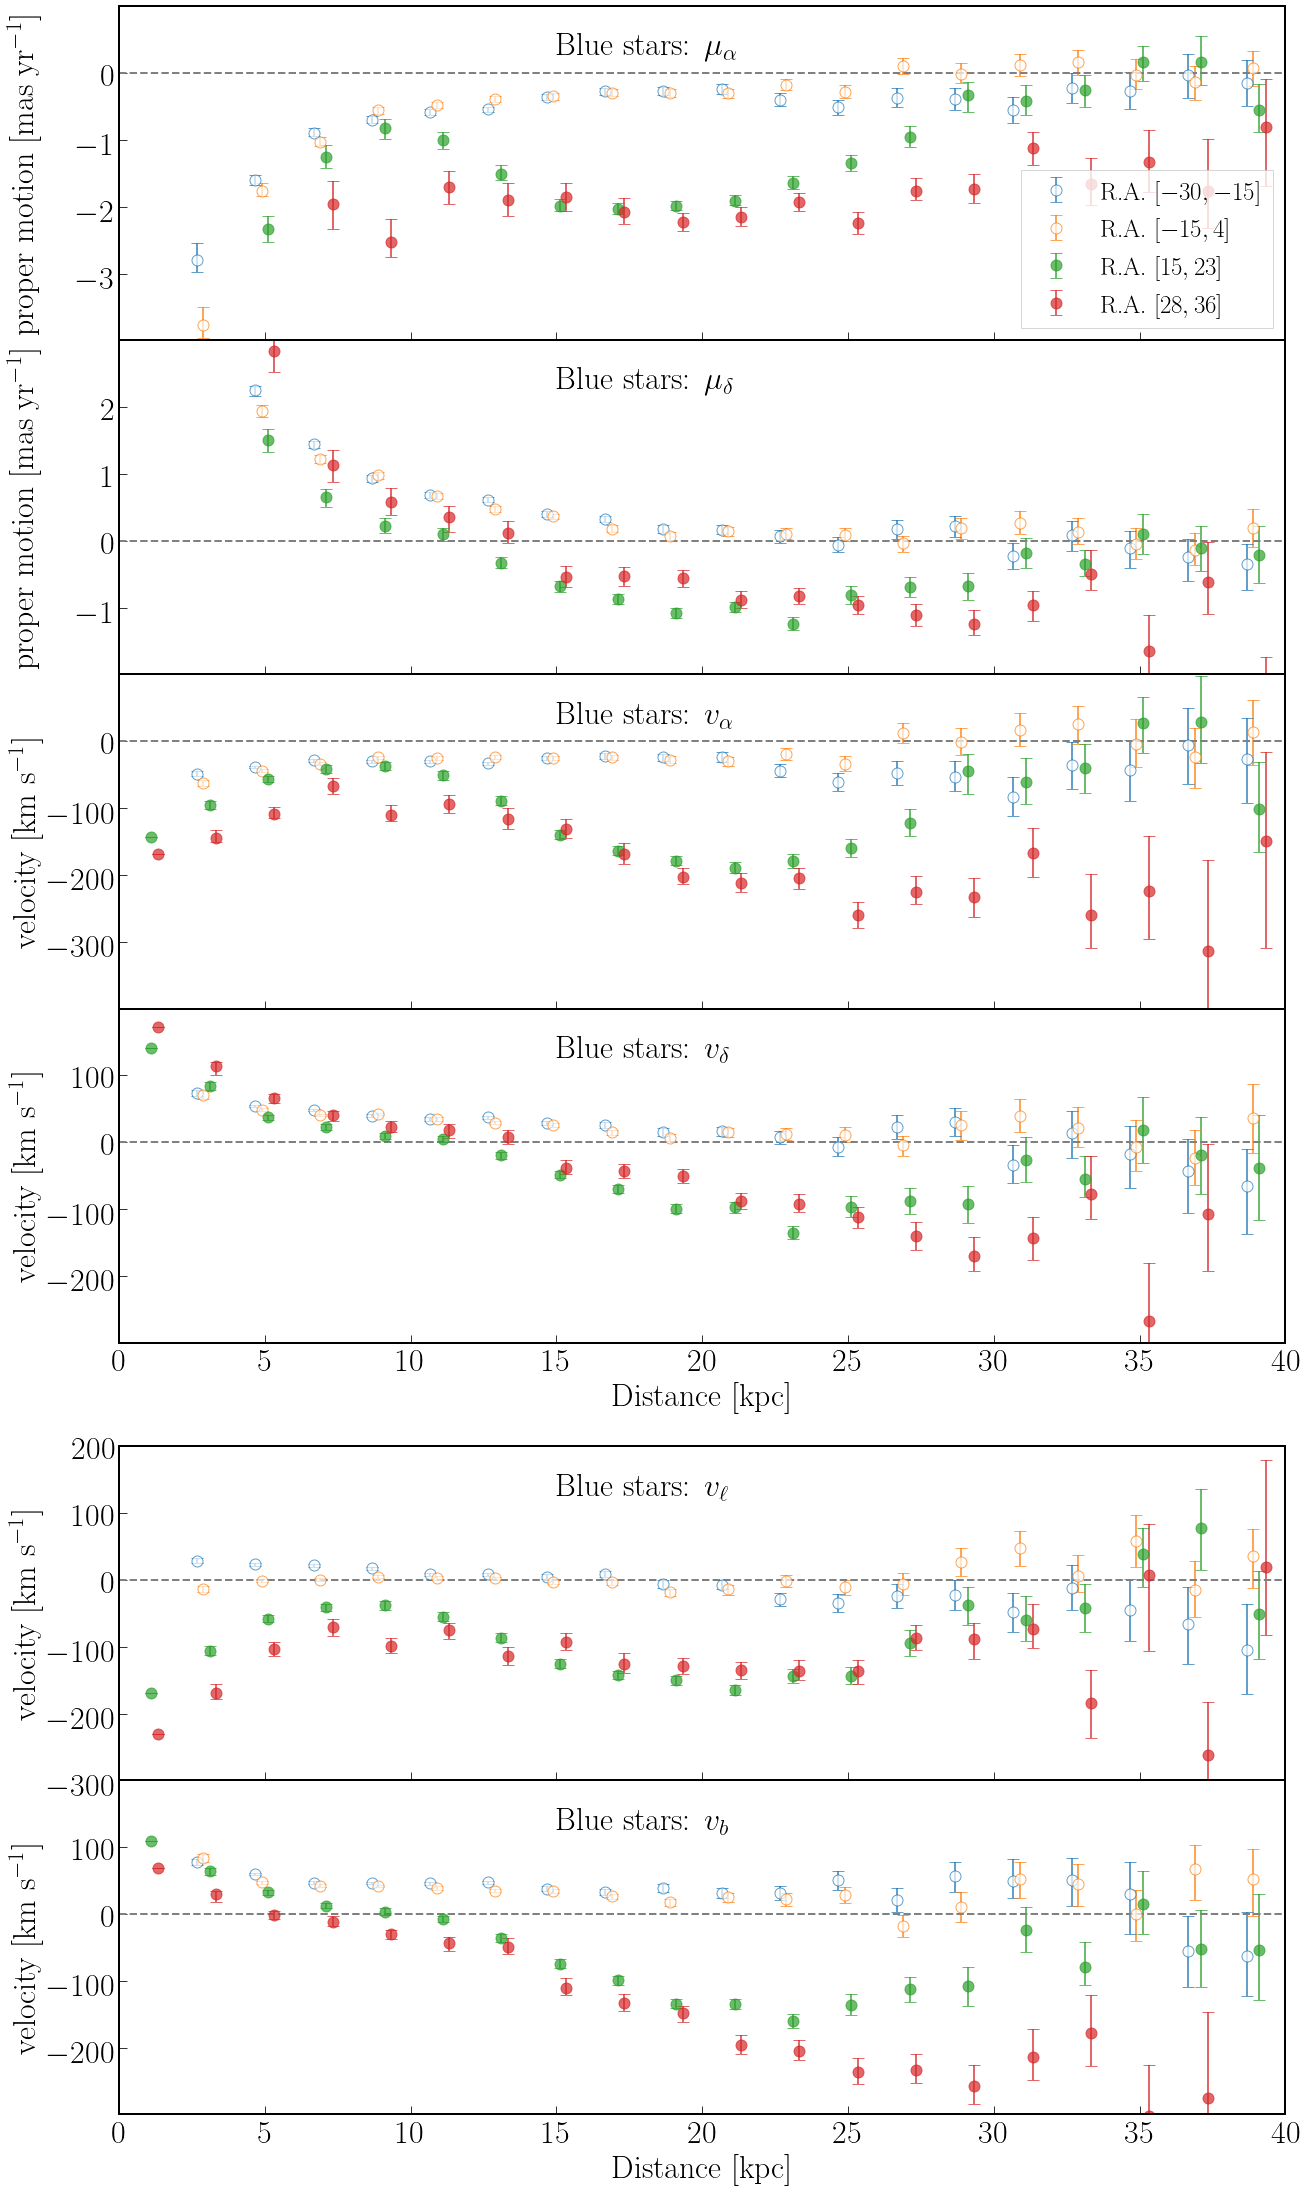

In [324]:
sgrb()

In [329]:
def sgrr():
    fig=plt.figure(figsize=(18,32))
    
    #ax=plt.subplot(4,1,1)
    ax=fig.add_axes([0.05,0.83,0.9,0.145])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-4,1)
    ax.set_xticks([5,10,15,20,25,30,35])
#    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_yticks([-3,-2,-1,0])
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    D = mr0.Dkpc
    pmra = mr0.pmra_cl_sm
 #   pmdec = mb0.pmdec_cl_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, markerfacecolor='white', alpha=0.7, label='R.A. $[-30,-15]$')
#    ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\delta$')
 
    D = mr1.Dkpc
    pmra = mr1.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, markerfacecolor='white',alpha=0.7, label='R.A. $[-15, 4]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = mr2.Dkpc
    pmra = mr2.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label='R.A. $[15, 23]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = mr3.Dkpc
    pmra = mr3.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,alpha=0.7, label='R.A. $[28, 36]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    

    ax.text(15,0.2,r'Red stars: $\mu_\alpha$',fontsize=32)

    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend()
    
    #ax=plt.subplot(412)
    ax=fig.add_axes([0.05,0.685,0.9,0.145])
    ax.set_xlim(0,40)
    ax.set_ylim(-2,3)
    ax.set_xticks([5,10,15,20,25,30,35])
#    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_yticks([-1,0,1,2])
#    ax.set_xticks([])
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    D = mr0.Dkpc
    pmdec = mr0.pmdec_cl_sm
 #   pmdec = mb0.pmdec_cl_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  alpha=0.7, markerfacecolor='white',label='R.A. $[-30,-15]$')
#    ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\delta$')
 
    D = mr1.Dkpc
    pmdec = mr1.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7,markerfacecolor='white', label='R.A. $[-15, 4]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = mr2.Dkpc
    pmdec = mr2.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label='R.A. $[15, 23]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = mr3.Dkpc
    pmdec = mr3.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,alpha=0.7, label='R.A. $[28, 36]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    

    ax.text(15,2.2,r'Red stars: $\mu_\delta$',fontsize=32)

    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
#    plt.legend()
    #
#    ax=plt.subplot(413)
    ax=fig.add_axes([0.05,0.54,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-400,100)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)  
    ax.set_xticks([5,10,15,20,25,30,35])
    #ax.set_xlabel('Distance [kpc]',fontsize=32)
    # binned medians to be more quantitative 
    ax.set_yticks([-300,-200,-100,0])
#    ax.set_xticks([])
    D = mr0.Dkpc
    vra = mr0.v_ra_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',alpha=0.7, label=r'Blue stars within R.A. $[-30,-15]$: $v_\alpha$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = mr1.Dkpc
    vra = mr1.v_ra_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',  alpha=0.7, label=r'Blue stars within R.A. $[-15,4]$: $v_\alpha$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mr2.Dkpc
    vra = mr2.v_ra_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. $[15,23]$: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mr3.Dkpc
    vra = mr3.v_ra_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. $[28,36]$: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,20,r'Red stars: $v_\alpha$',fontsize=32)
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')




#    ax=plt.subplot(414)
    ax=fig.add_axes([0.05,0.395,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
#    ax.set_xticks([5,10,15,20,25,30,35])
    ax.set_yticks([-200,-100,0,100])
#    ax.set_xticks([])    
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = mr0.Dkpc
    vdec = mr0.v_dec_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7,  markerfacecolor='white',label=r'Blue stars within R.A. $[-30,-15]$: $v_\alpha$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = mr1.Dkpc
    vdec = mr1.v_dec_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  alpha=0.7,  markerfacecolor='white',label=r'Blue stars within R.A. $[-15,4]$: $v_\alpha$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mr2.Dkpc
    vdec = mr2.v_dec_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. $[15,23$]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mr3.Dkpc
    vdec = mr3.v_dec_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [28,36]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,120,r'Red stars: $v_\delta$',fontsize=32)
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)

    ax.set_xlabel('Distance [kpc]',fontsize=32)

    ax=fig.add_axes([0.05,0.205,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
    ax.set_xticks([5,10,15,20,25,30,35])    
#    ax.set_xticks([5,10,15,20,25,30,35])
    
#    ax.set_xticks([])
#    ax.set_yticks([-200,-100,0,100])
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = mr0.Dkpc
    vdec = mr0.v_lcosb_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white' ,alpha=0.7, label=r'R.A. $[-30,-15]$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = mr1.Dkpc
    vdec = mr1.v_lcosb_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',  alpha=0.7, label=r'R.A. $[-15,4]$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mr2.Dkpc
    vdec = mr2.v_lcosb_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [15,23]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mr3.Dkpc
    vdec = mr3.v_lcosb_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [28,36]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,120,r'Red stars: $v_\ell$',fontsize=32)
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)
    ax=fig.add_axes([0.05,0.06,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
    ax.set_yticks([-200,-100,0,100])

    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = mr0.Dkpc
    vdec = mr0.v_b_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white', alpha=0.7, label=r'R.A. $[-30,-15]$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = mr1.Dkpc
    vdec = mr1.v_b_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white' , alpha=0.7, label=r'R.A. $[-15,4]$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mr2.Dkpc
    vdec = mr2.v_b_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'R.A. $[15,23]$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = mr3.Dkpc
    vdec = mr3.v_b_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'R.A. $[28,36]$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,120,r'Red stars: $v_b$',fontsize=32)
#    plt.legend()
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)

    
    ax.set_xlabel('Distance [kpc]',fontsize=32)

    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
#    plt.savefig(pwd+'dblue_sm_sagibl.pdf')
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    plt.savefig(pwd+'dred_sm_sagi.pdf')

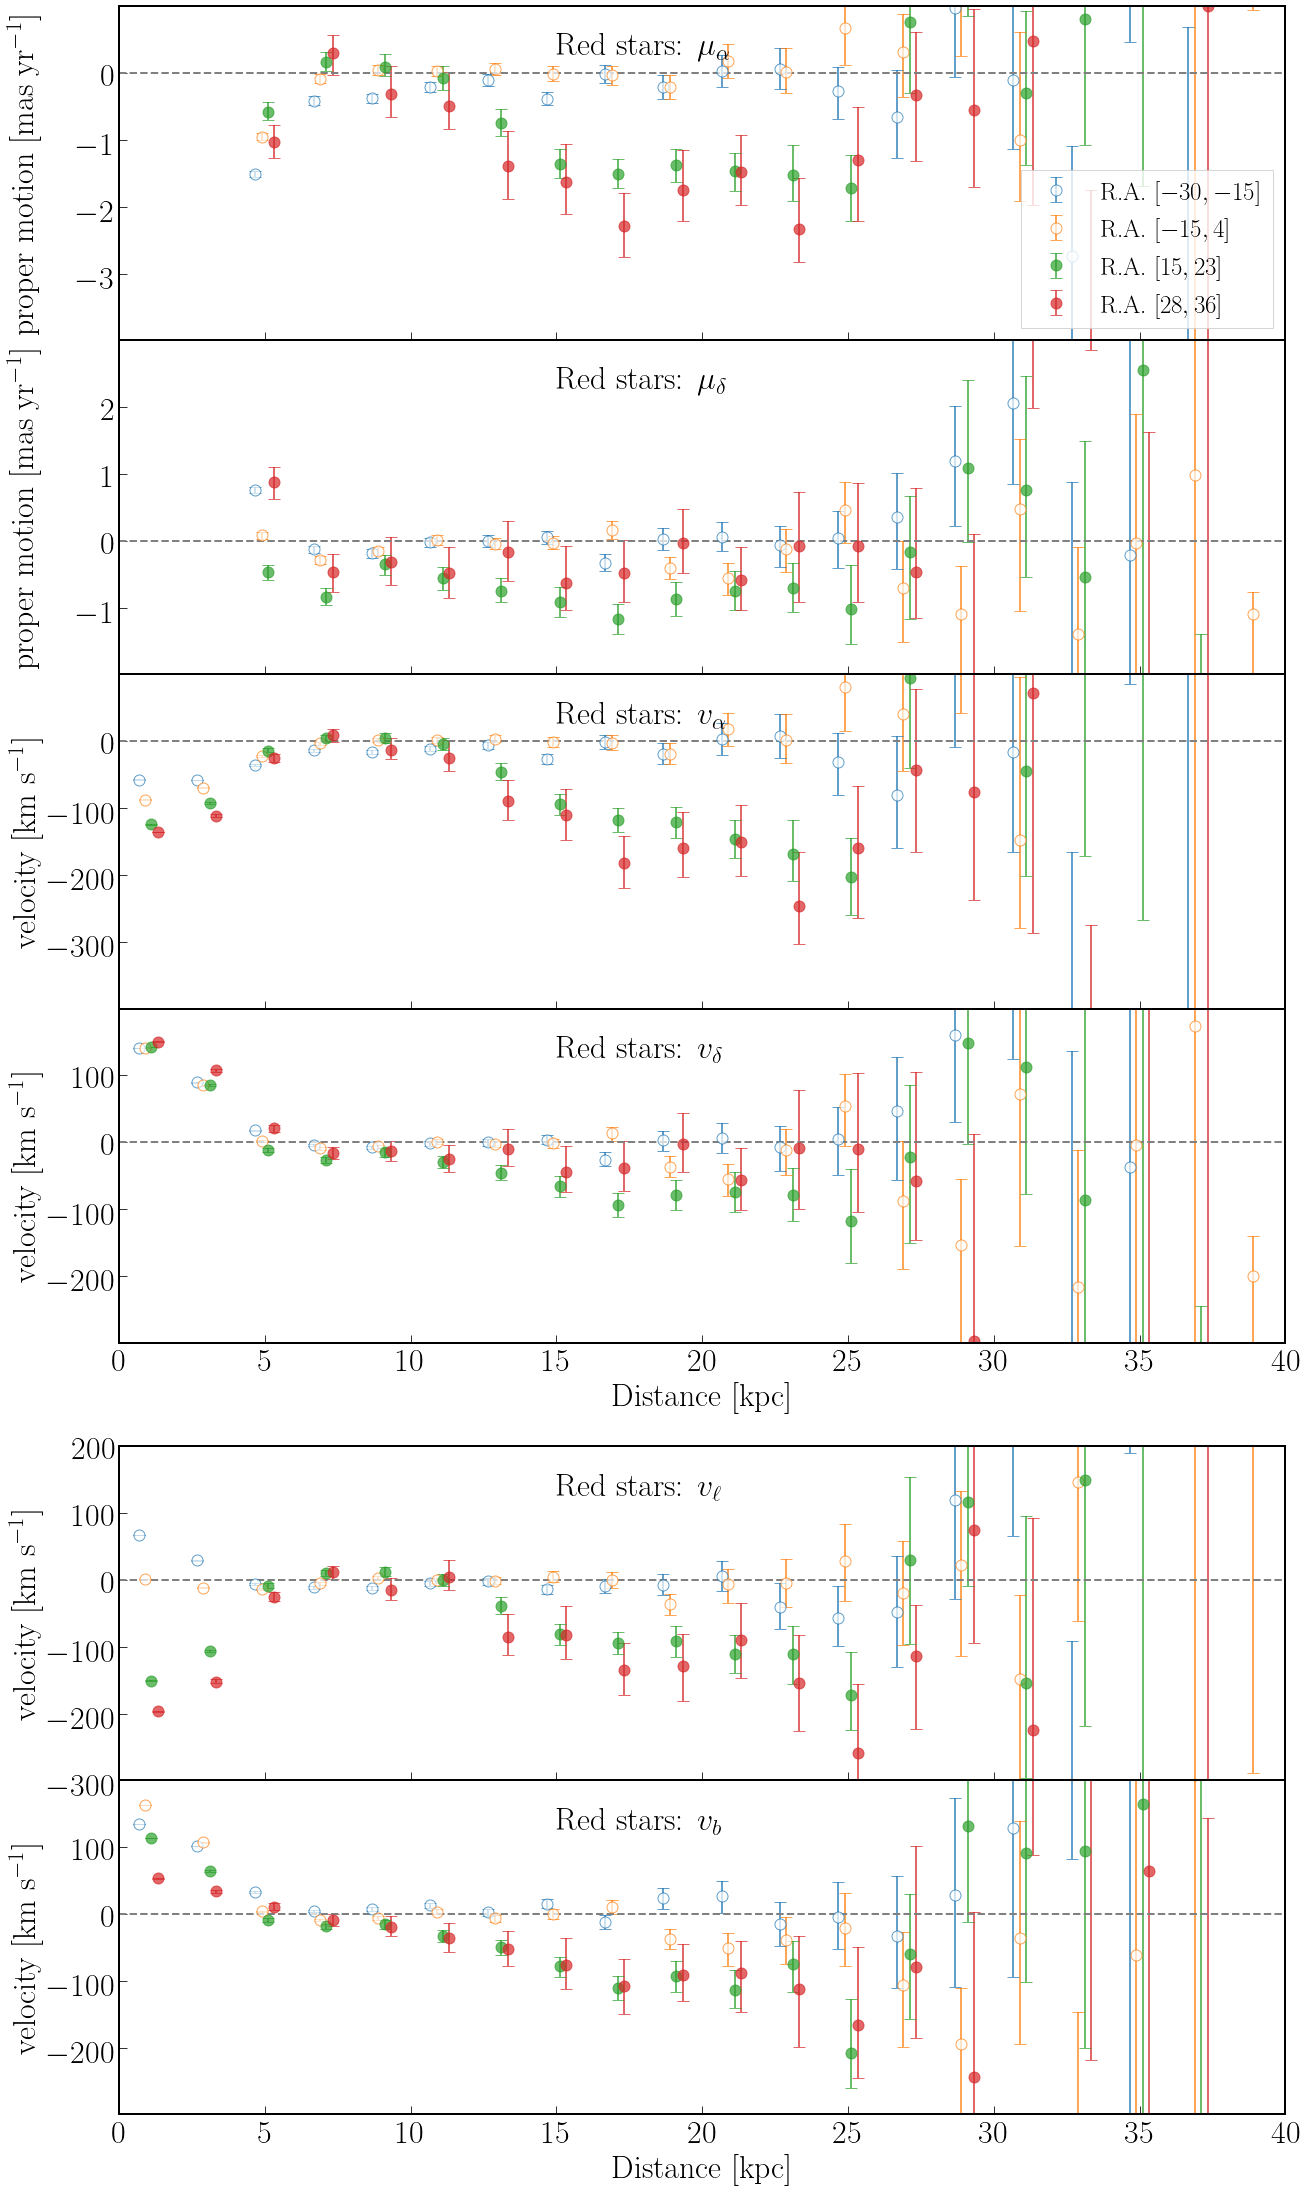

In [330]:
sgrr()

In [335]:
def sgra():
    fig=plt.figure(figsize=(18,32))
    
    #ax=plt.subplot(4,1,1)
    ax=fig.add_axes([0.05,0.83,0.9,0.145])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-4,1)
    ax.set_xticks([5,10,15,20,25,30,35])
#    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_yticks([-3,-2,-1,0])
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    D = ms0.Dkpc
    pmra = ms0.pmra_cl_sm
 #   pmdec = mb0.pmdec_cl_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, markerfacecolor='white', alpha=0.7, label='R.A. $[-30,-15]$')
#    ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\delta$')
 
    D = ms1.Dkpc
    pmra = ms1.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, markerfacecolor='white',alpha=0.7, label='R.A. $[-15, 4]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = ms2.Dkpc
    pmra = ms2.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label='R.A. $[15, 23]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = ms3.Dkpc
    pmra = ms3.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,alpha=0.7, label='R.A. $[28, 36]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    

    ax.text(15,0.2,r'All stars: $\mu_\alpha$',fontsize=32)

    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend()
    
    #ax=plt.subplot(412)
    ax=fig.add_axes([0.05,0.685,0.9,0.145])
    ax.set_xlim(0,40)
    ax.set_ylim(-2,3)
    ax.set_xticks([5,10,15,20,25,30,35])
#    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_yticks([-1,0,1,2])
#    ax.set_xticks([])
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    D = ms0.Dkpc
    pmdec = ms0.pmdec_cl_sm
 #   pmdec = mb0.pmdec_cl_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  alpha=0.7, markerfacecolor='white',label='R.A. $[-30,-15]$')
#    ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\delta$')
 
    D = ms1.Dkpc
    pmdec = ms1.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7,markerfacecolor='white', label='R.A. $[-15, 4]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = ms2.Dkpc
    pmdec = ms2.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label='R.A. $[15, 23]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    
    D = ms3.Dkpc
    pmdec = ms3.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,alpha=0.7, label='R.A. $[28, 36]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    

    ax.text(15,2.2,r'All stars: $\mu_\delta$',fontsize=32)

    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
#    plt.legend()
    #
#    ax=plt.subplot(413)
    ax=fig.add_axes([0.05,0.54,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-400,100)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)  
    ax.set_xticks([5,10,15,20,25,30,35])
    #ax.set_xlabel('Distance [kpc]',fontsize=32)
    # binned medians to be more quantitative 
    ax.set_yticks([-300,-200,-100,0])
#    ax.set_xticks([])
    D = ms0.Dkpc
    vra = ms0.v_ra_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',alpha=0.7, label=r'Blue stars within R.A. $[-30,-15]$: $v_\alpha$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = ms1.Dkpc
    vra = ms1.v_ra_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',  alpha=0.7, label=r'Blue stars within R.A. $[-15,4]$: $v_\alpha$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms2.Dkpc
    vra = ms2.v_ra_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. $[15,23]$: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms3.Dkpc
    vra = ms3.v_ra_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. $[28,36]$: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,20,r'All stars: $v_\alpha$',fontsize=32)
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')




#    ax=plt.subplot(414)
    ax=fig.add_axes([0.05,0.395,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
#    ax.set_xticks([5,10,15,20,25,30,35])
    ax.set_yticks([-200,-100,0,100])
#    ax.set_xticks([])    
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = ms0.Dkpc
    vdec = ms0.v_dec_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7,  markerfacecolor='white',label=r'Blue stars within R.A. $[-30,-15]$: $v_\alpha$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = ms1.Dkpc
    vdec = ms1.v_dec_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  alpha=0.7,  markerfacecolor='white',label=r'Blue stars within R.A. $[-15,4]$: $v_\alpha$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms2.Dkpc
    vdec = ms2.v_dec_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. $[15,23$]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms3.Dkpc
    vdec = ms3.v_dec_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [28,36]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,120,r'All stars: $v_\delta$',fontsize=32)
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)

    ax.set_xlabel('Distance [kpc]',fontsize=32)

    ax=fig.add_axes([0.05,0.205,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
    ax.set_xticks([5,10,15,20,25,30,35])    
#    ax.set_xticks([5,10,15,20,25,30,35])
    
#    ax.set_xticks([])
#    ax.set_yticks([-200,-100,0,100])
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = ms0.Dkpc
    vdec = ms0.v_lcosb_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white' ,alpha=0.7, label=r'R.A. $[-30,-15]$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = ms1.Dkpc
    vdec = ms1.v_lcosb_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',  alpha=0.7, label=r'R.A. $[-15,4]$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms2.Dkpc
    vdec = ms2.v_lcosb_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [15,23]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms3.Dkpc
    vdec = ms3.v_lcosb_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [28,36]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,120,r'All stars: $v_\ell$',fontsize=32)
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)
    ax=fig.add_axes([0.05,0.06,0.9,0.145])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
    ax.set_yticks([-200,-100,0,100])

    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = ms0.Dkpc
    vdec = ms0.v_b_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white', alpha=0.7, label=r'R.A. $[-30,-15]$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = ms1.Dkpc
    vdec = ms1.v_b_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white' , alpha=0.7, label=r'R.A. $[-15,4]$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms2.Dkpc
    vdec = ms2.v_b_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'R.A. $[15,23]$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms3.Dkpc
    vdec = ms3.v_b_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'R.A. $[28,36]$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,120,r'All stars: $v_b$',fontsize=32)
#    plt.legend()
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)

    
    ax.set_xlabel('Distance [kpc]',fontsize=32)

    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
#    plt.savefig(pwd+'dblue_sm_sagibl.pdf')
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    plt.savefig(pwd+'dall_sm_sagi.pdf')

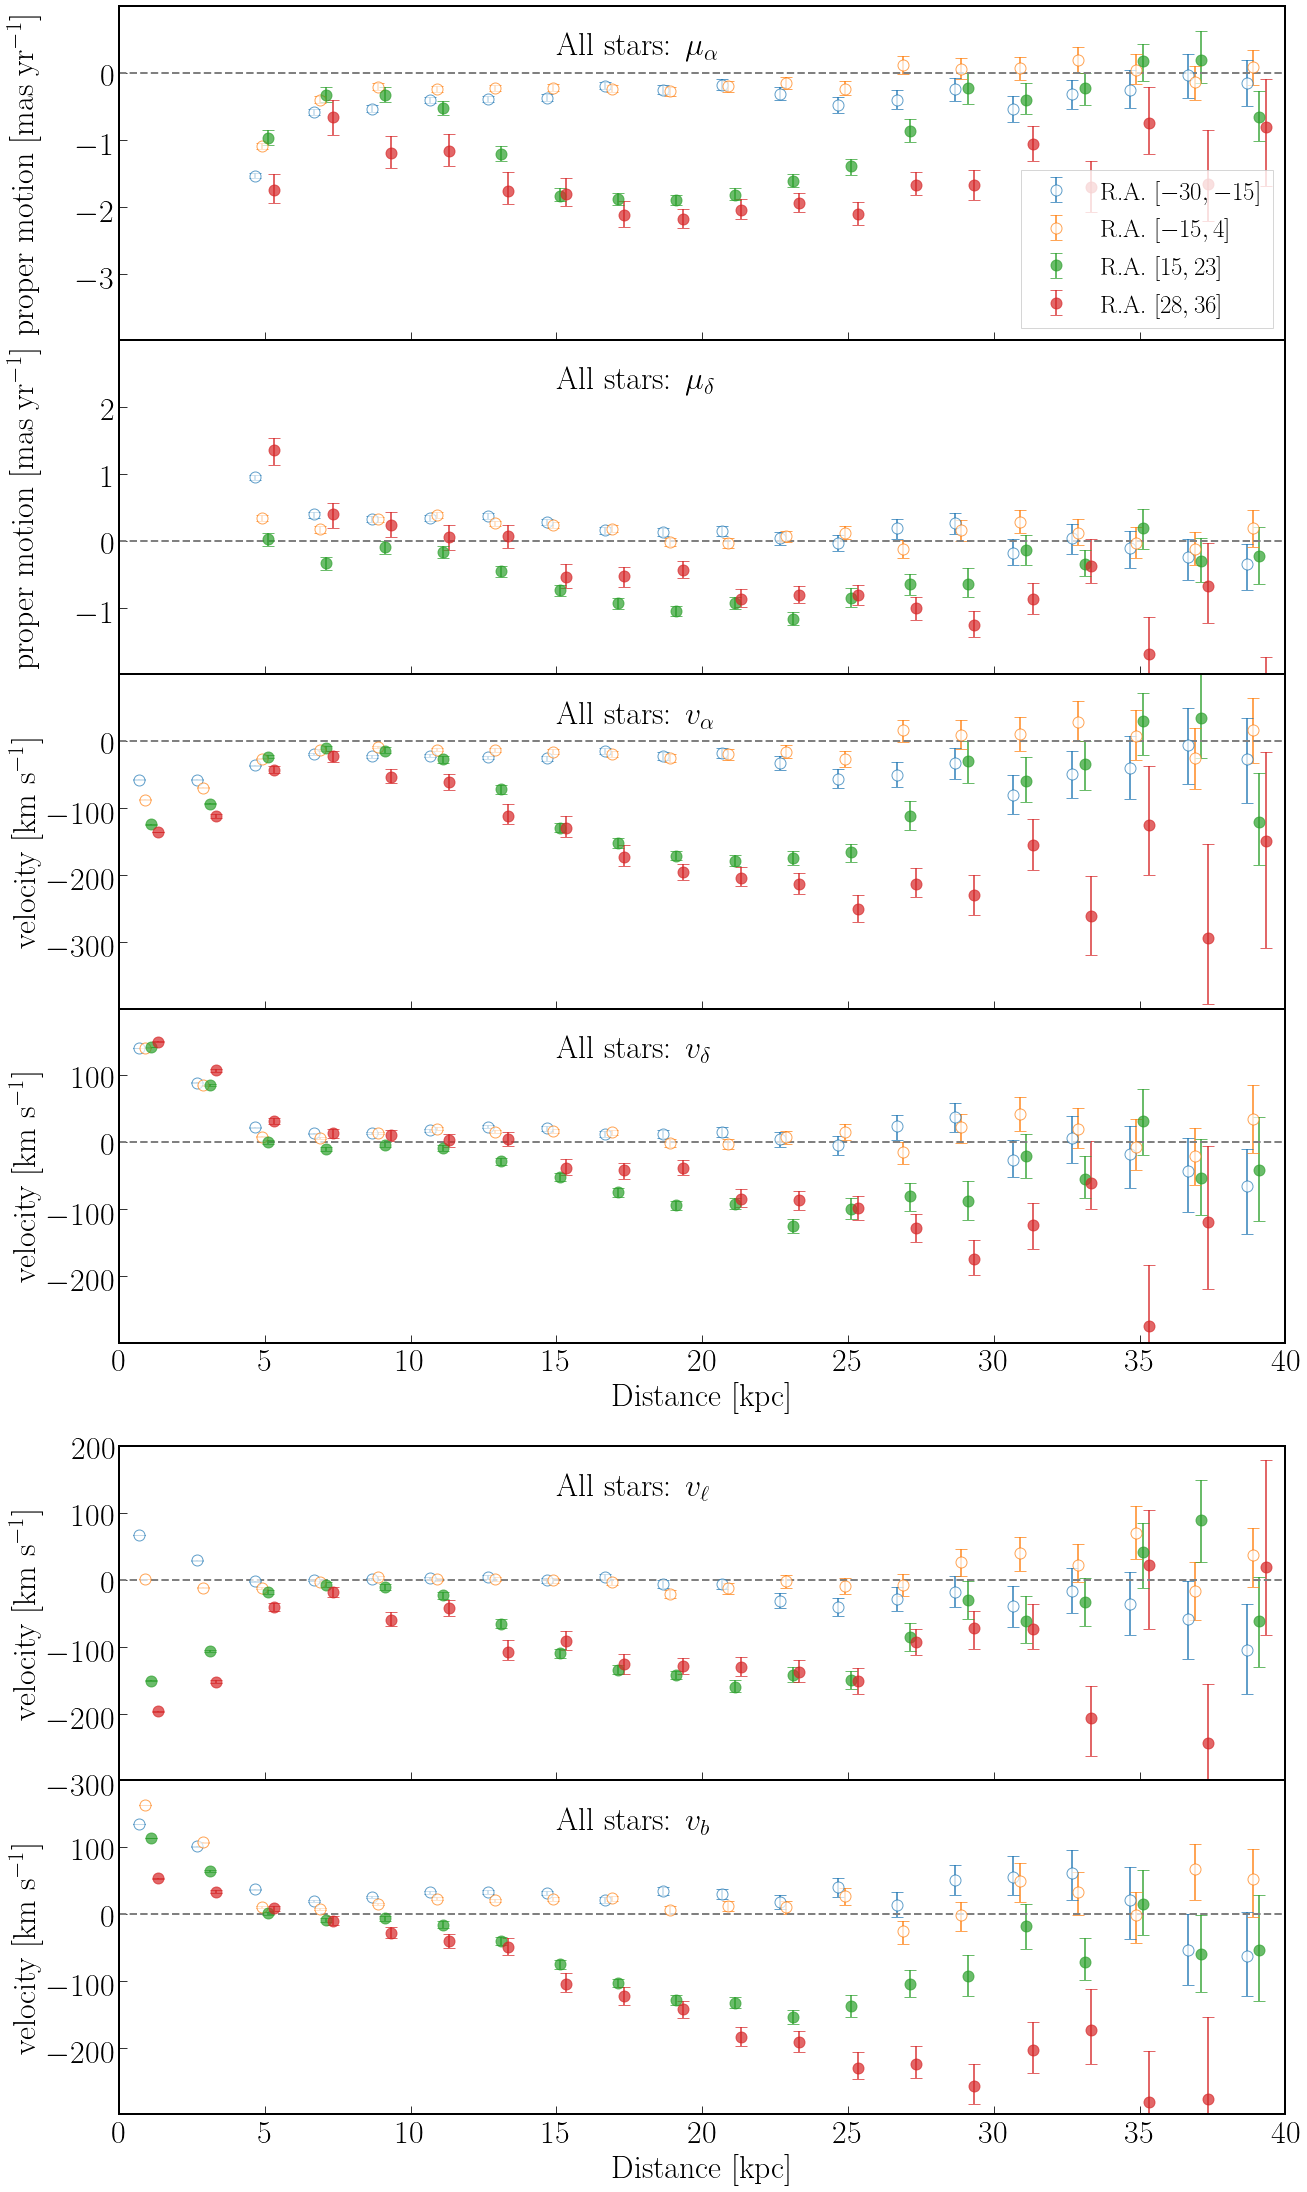

In [336]:
sgra()

In [49]:
def sgra1():
    fig=plt.figure(figsize=(8,6))
    plt.ylabel('velocity [km s$^{-1}$]',fontsize=32,labelpad=70)
    ax=fig.add_axes([0.05,0.5,0.9,0.45])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
    ax.set_yticks([-200,-100,0,100])
    ax.set_xticks([5,10,15,20,25,30,35])    
#    ax.set_xticks([5,10,15,20,25,30,35])
    
#    ax.set_xticks([])
#    ax.set_yticks([-200,-100,0,100])
    # binned medians to be more quantitative 
    
    D = ms0.Dkpc
    vdec = ms0.v_lcosb_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white' ,alpha=0.7, label=r'R.A. $[-30,-15]$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = ms1.Dkpc
    vdec = ms1.v_lcosb_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',  alpha=0.7, label=r'R.A. $[-15,4]$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms2.Dkpc
    vdec = ms2.v_lcosb_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [15,23]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms3.Dkpc
    vdec = ms3.v_lcosb_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'Blue stars within R.A. [28,36]: $v_\alpha$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,100,r'All stars: $v_\ell$',fontsize=32)
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)
    ax=fig.add_axes([0.05,0.05,0.9,0.45])
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-300,200)
    ax.set_yticks([-200,-100,0,100])

#    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = ms0.Dkpc
    vdec = ms0.v_b_sm
 #   vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white', alpha=0.7, label=r'R.A. $[-30,-15]$')
 #   ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = ms1.Dkpc
    vdec = ms1.v_b_sm
 #   vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
 #   x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white' , alpha=0.7, label=r'R.A. $[-15,4]$')
 #   ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms2.Dkpc
    vdec = ms2.v_b_sm
#    vdec = mb2.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'R.A. $[15,23]$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    D = ms3.Dkpc
    vdec = ms3.v_b_sm
#    vdec = mb3.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label=r'R.A. $[28,36]$')
#    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
        
    ax.text(15,100,r'All stars: $v_b$',fontsize=32)
#    plt.legend()
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)

    
    ax.set_xlabel('Distance [kpc]',fontsize=32)

    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
#    plt.savefig(pwd+'dblue_sm_sagibl.pdf')
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    plt.savefig('../Dropbox/dallsagi.png')

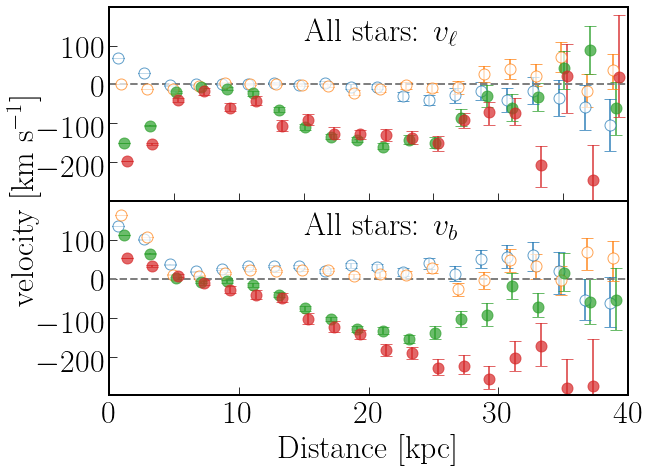

In [50]:
sgra1()

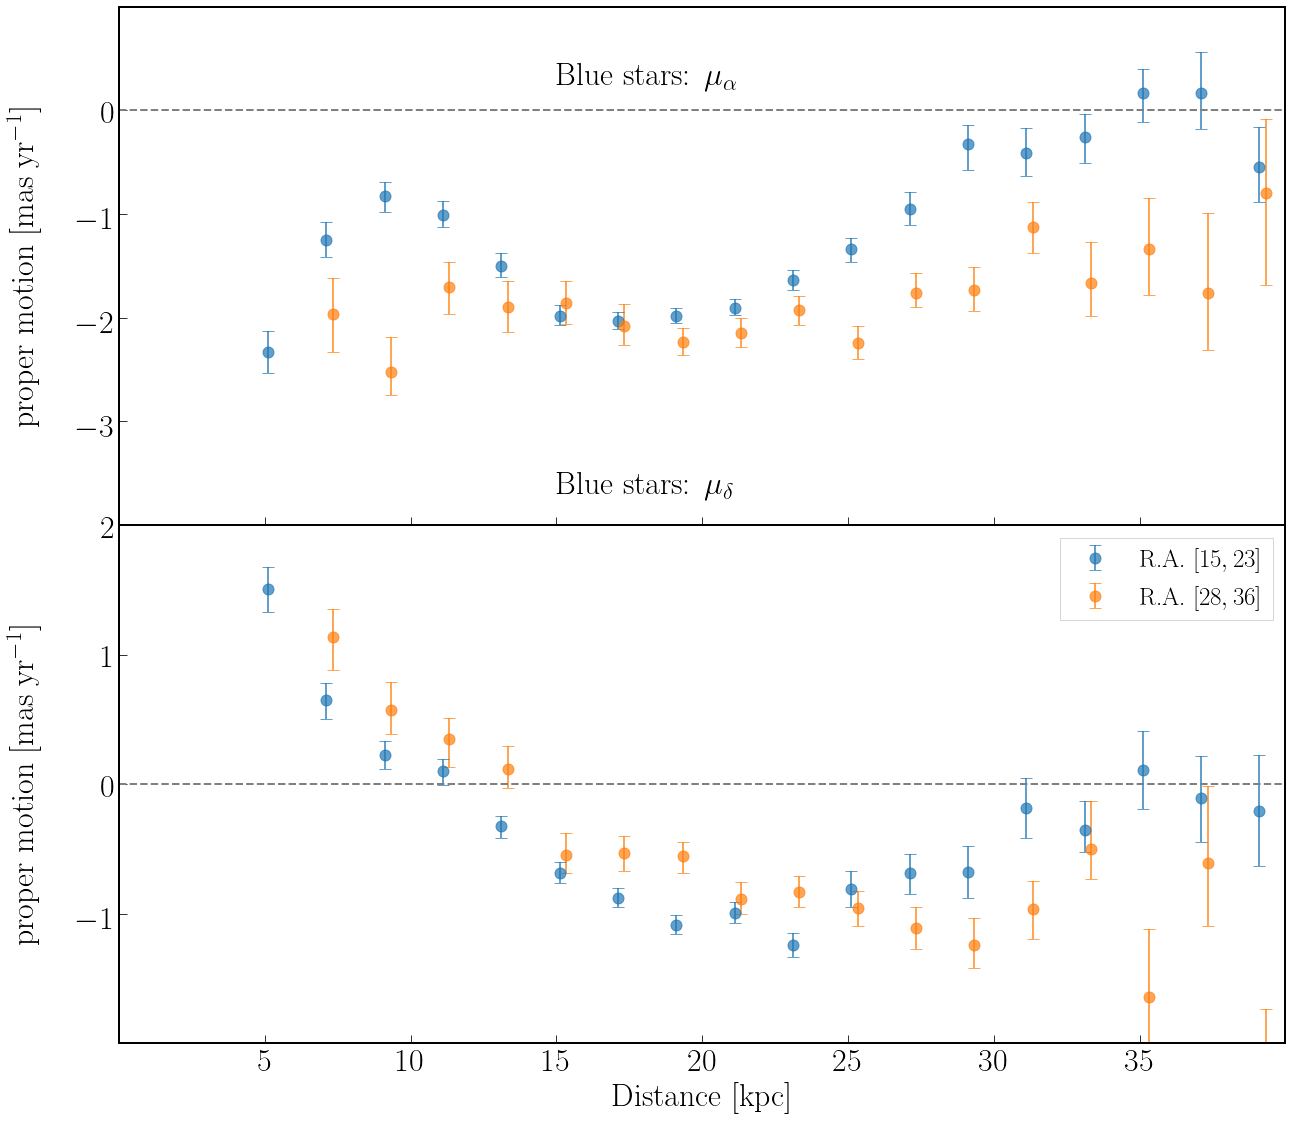

In [44]:
fig=plt.figure(figsize=(18,16))

#ax=plt.subplot(4,1,1)
ax=fig.add_axes([0.05,0.5,0.9,0.45])
#ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
#ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(0,40)
ax.set_ylim(-4,1)
ax.set_xticks([5,10,15,20,25,30,35])
#    ax.set_xlabel('Distance [kpc]',fontsize=32)
ax.set_yticks([-3,-2,-1,0])
ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
# binned medians to be more quantitative 
D = mb0.Dkpc
pmra = mb0.pmra_cl_sm
#   pmdec = mb0.pmdec_cl_sm
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, markerfacecolor='white', alpha=0.7, label='R.A. $[-30,-15]$')
#    ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\delta$')

D = mb1.Dkpc
pmra = mb1.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, markerfacecolor='white',alpha=0.7, label='R.A. $[-15, 4]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')

D = mb2.Dkpc
pmra = mb2.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label='R.A. $[15, 23]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')

D = mb3.Dkpc
pmra = mb3.pmra_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,alpha=0.7, label='R.A. $[28, 36]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')


ax.text(15,0.2,r'Blue stars: $\mu_\alpha$',fontsize=32)


xL = np.linspace(0,200)
ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
#plt.title('proper motion vs. distance for blue stars')


#ax=plt.subplot(412)
ax=fig.add_axes([0.05,0.05,0.9,0.45])
ax.set_xlim(0,40)
ax.set_ylim(-2,2)
ax.set_xticks([5,10,15,20,25,30,35])
#    ax.set_xlabel('Distance [kpc]',fontsize=32)
ax.set_yticks([-1,0,1,2])
#    ax.set_xticks([])
ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
# binned medians to be more quantitative 
D = mb0.Dkpc
pmdec = mb0.pmdec_cl_sm
#   pmdec = mb0.pmdec_cl_sm
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  alpha=0.7, markerfacecolor='white',label='R.A. $[-30,-15]$')
#    ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\delta$')

D = mb1.Dkpc
pmdec = mb1.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#ax.errorbar(x1Bin-0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7,markerfacecolor='white', label='R.A. $[-15, 4]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')

D = mb2.Dkpc
pmdec = mb2.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, alpha=0.7, label='R.A. $[15, 23]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')

D = mb3.Dkpc
pmdec = mb3.pmdec_cl_sm
#    pmdec = mb1.pmdec_cl_sm  
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin+0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,alpha=0.7, label='R.A. $[28, 36]$')
#    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')


ax.text(15,2.2,r'Blue stars: $\mu_\delta$',fontsize=32)


xL = np.linspace(0,200)
ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
#plt.title('proper motion vs. distance for blue stars')
#    plt.legend()
plt.legend()
plt.xlabel('Distance [kpc]')

#plt.savefig('../Documents/final/1/dblue_sm.pdf')
#    plt.savefig(pwd+'dblue_sm_sagibl.pdf')
#plt.savefig('../Documents/final/1/dblue_sm.pdf')
plt.savefig('../Documents/final/ppt/dblue_sm_sagi_w.pdf')

## with/without Sgr.

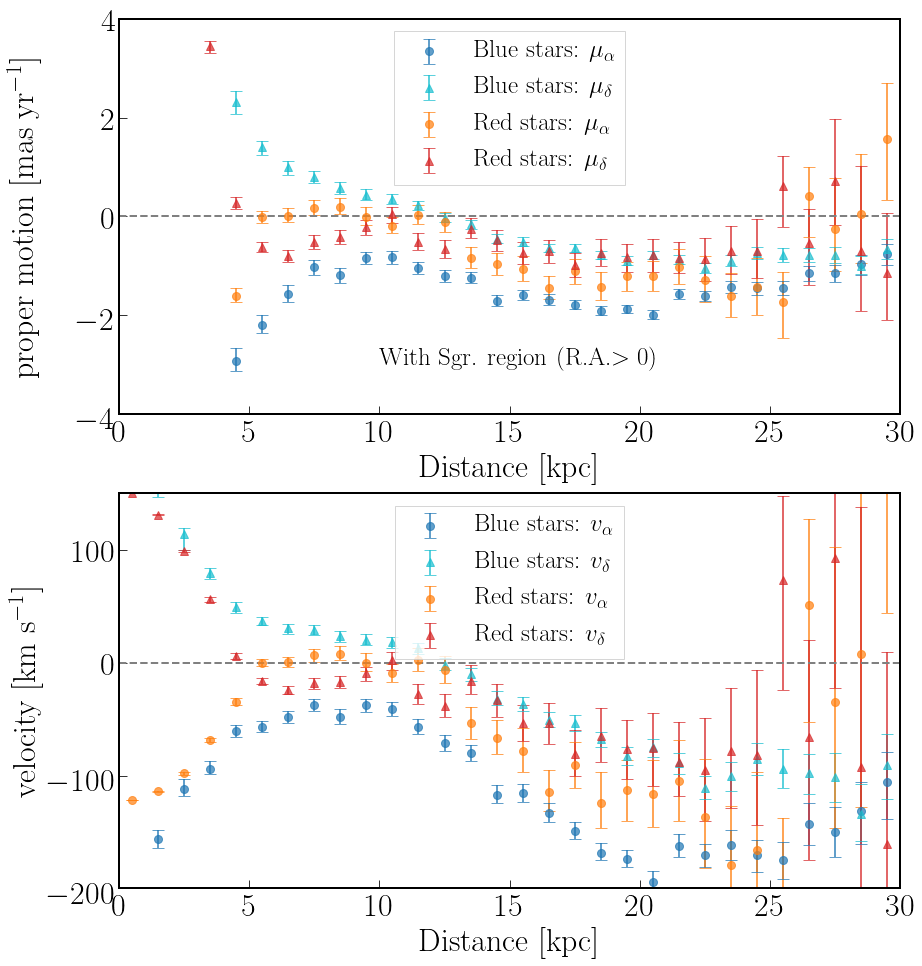

In [25]:
    t=[ms,mb[mb.i_sdsscentroid_ra>0],mr[mr.i_sdsscentroid_ra>0]]
    c=['All','Blue','Red']
    color1=['darkblue','tab:blue','tab:orange']
    color2=['darkred','tab:cyan','tab:red']
    fig=plt.figure(figsize=(14,16))
    ax = plt.subplot(212)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-200,150)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        D = t[i].Dkpc
        vra = t[i].v_ra_sm
        vdec = t[i].v_dec_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 30, 30, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 30, 30, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i] ,capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i], capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    ax = plt.subplot(211)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-4,4)
    plt.text(10,-3,'With Sgr. region (R.A.$>0$)')
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        D = t[i].Dkpc
        pmra = t[i].pmra_cl_sm
        pmdec = t[i].pmdec_cl_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 30, 30, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 30, 30, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    plt.savefig('../Documents/final/sgr/d_all_wsgr.pdf')
    #plt.savefig(pwd+'d_all_sgr.pdf')

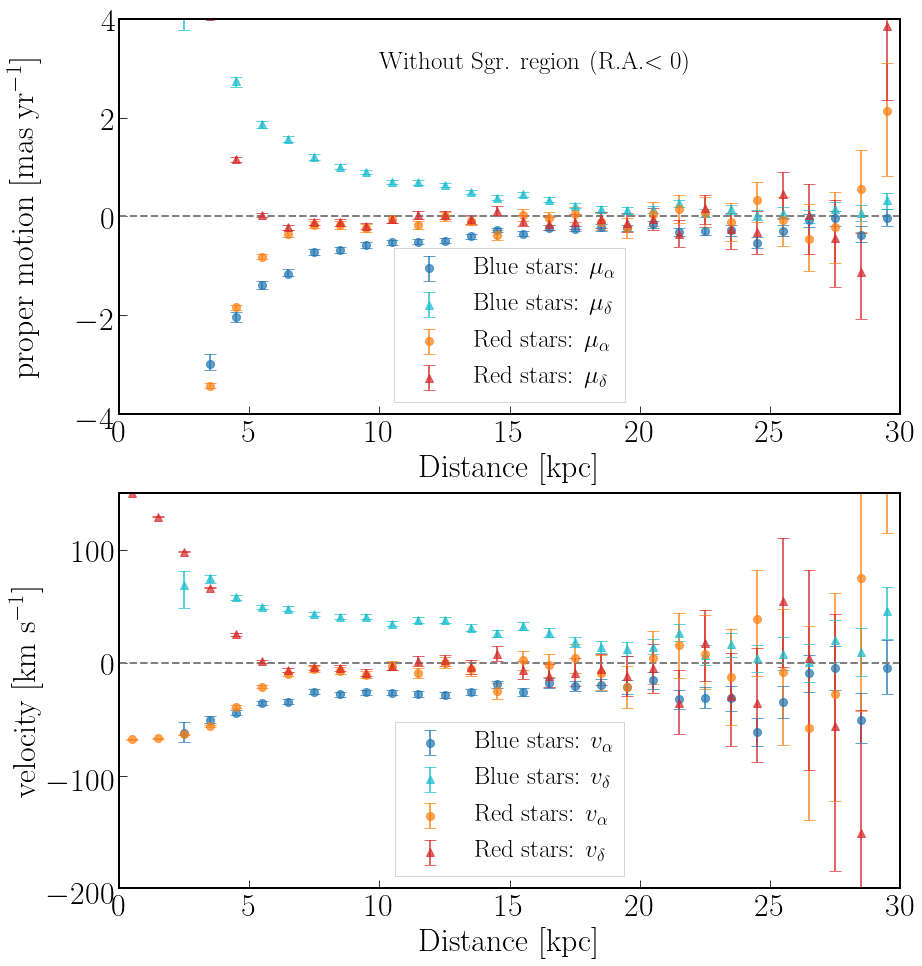

In [24]:
    t=[ms,mb[mb.i_sdsscentroid_ra<0],mr[mr.i_sdsscentroid_ra<0]]
    c=['All','Blue','Red']
    color1=['darkblue','tab:blue','tab:orange']
    color2=['darkred','tab:cyan','tab:red']
    fig=plt.figure(figsize=(14,16))
    ax = plt.subplot(212)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-200,150)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        D = t[i].Dkpc
        vra = t[i].v_ra_sm
        vdec = t[i].v_dec_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 30, 30, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 30, 30, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i] ,capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i], capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    ax = plt.subplot(211)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-4,4)
    plt.text(10,3,'Without Sgr. region (R.A.$<0$)')
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        D = t[i].Dkpc
        pmra = t[i].pmra_cl_sm
        pmdec = t[i].pmdec_cl_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 30, 30, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 30, 30, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    plt.savefig('../Documents/final/sgr/d_all_wosgr.pdf')
    #plt.savefig(pwd+'d_all_wosgr.pdf')

In [370]:
def d_all_sgr():
    t=[ms,mb[mb.i_sdsscentroid_ra>0],mr[mr.i_sdsscentroid_ra>0]]
    c=['All','Blue','Red']
    color1=['darkblue','tab:blue','tab:orange']
    color2=['darkred','tab:cyan','tab:red']
    fig=plt.figure(figsize=(14,16))
    ax = plt.subplot(212)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-200,150)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        D = t[i].Dkpc
        vra = t[i].v_ra_sm
        vdec = t[i].v_dec_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i] ,capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i], capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    ax = plt.subplot(211)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-4,4)
    plt.text(5,3,'R.A.$>0$')
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        D = t[i].Dkpc
        pmra = t[i].pmra_cl_sm
        pmdec = t[i].pmdec_cl_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    #plt.savefig('../Documents/final/1/d_all_sm.pdf')
    plt.savefig(pwd+'d_all_sgr.pdf')

In [371]:
def d_all_wosgr():
    t=[ms,mb[mb.i_sdsscentroid_ra<0],mr[mr.i_sdsscentroid_ra<0]]
    c=['All','Blue','Red']
    color1=['darkblue','tab:blue','tab:orange']
    color2=['darkred','tab:cyan','tab:red']
    fig=plt.figure(figsize=(14,16))
    ax = plt.subplot(212)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-200,150)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        D = t[i].Dkpc
        vra = t[i].v_ra_sm
        vdec = t[i].v_dec_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i] ,capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i], capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $v_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00, linestyle='dashed',c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    ax = plt.subplot(211)
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,30)
    ax.set_ylim(-4,4)
    plt.text(5,3,'R.A.$<0$')
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    for i in range(3):
        if i ==0:
            continue
        D = t[i].Dkpc
        pmra = t[i].pmra_cl_sm
        pmdec = t[i].pmdec_cl_sm
        x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 30, 60, 0)
        x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 30, 60, 0)
        ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',color=color1[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_\alpha$')
        ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',color=color2[i],capsize=6, markersize=8, alpha=0.7, label=c[i]+r' stars: $\mu_\delta$')
        xL = np.linspace(0,100)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for stars')
    plt.legend()
    #plt.savefig('../Documents/final/1/d_all_sm.pdf')
    plt.savefig(pwd+'d_all_wosgr.pdf')

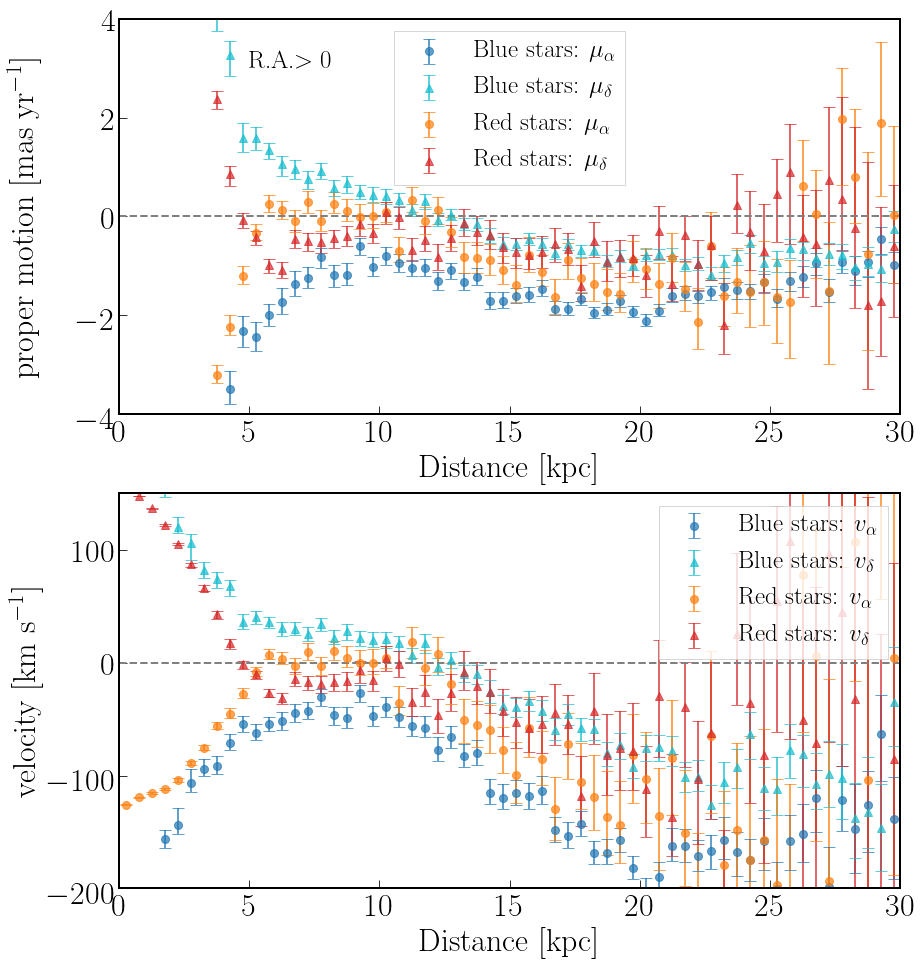

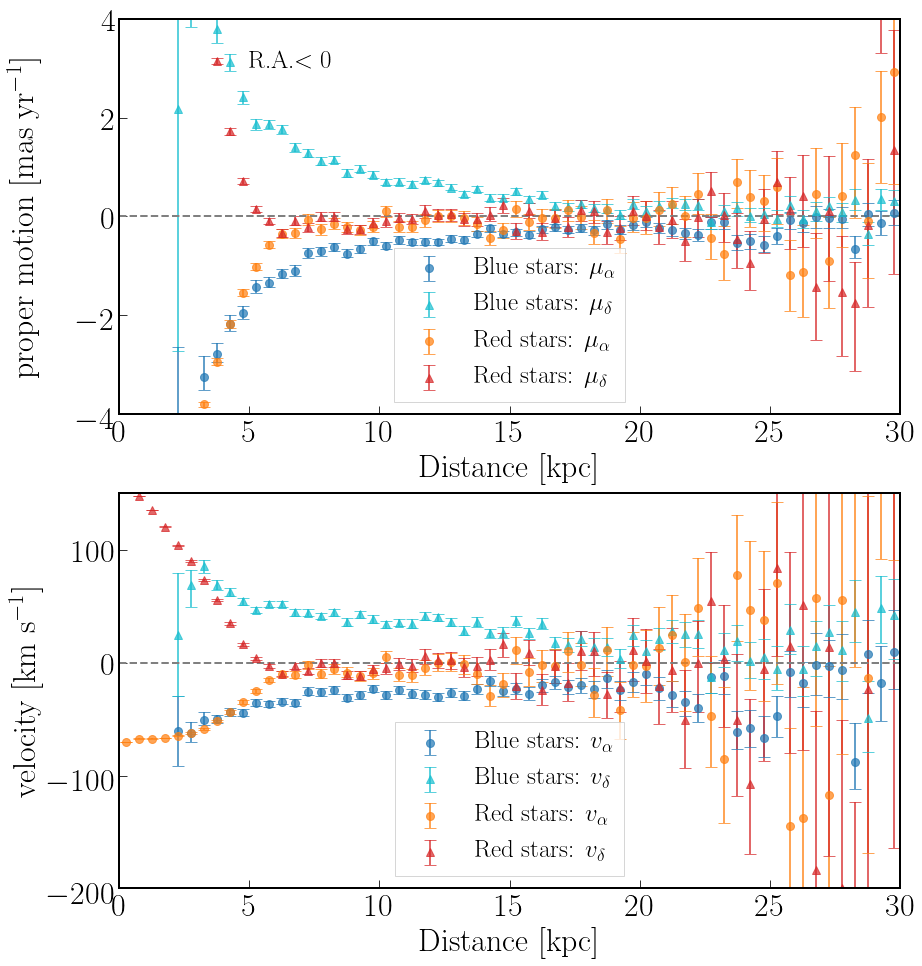

In [372]:
d_all_sgr()
d_all_wosgr()

In [350]:
pmram=[]
pmdecm=[]
pmrad=[]
pmdecd=[]
for i in range(33):
    t=mb[(mb.i_sdsscentroid_ra>-30+2*i)&(mb.i_sdsscentroid_ra<-28+2*i)&(mb.Dkpc>15)&(mb.Dkpc<35)]
    pmram.append(np.mean(t.v_ra_sm))
    pmdecm.append(np.mean(t.v_dec_sm))
    pmrad.append(stats.sem(t.v_ra_sm))
    pmdecd.append(stats.sem(t.v_dec_sm))

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [374]:
pmdecd

[9.174941517862422,
 10.161042139106609,
 10.317672175554458,
 10.845522772621084,
 12.60140236981098,
 12.259892249104052,
 13.95809102853179,
 11.643259482381305,
 10.632804536314207,
 11.251376723907212,
 10.133345276264926,
 14.294440377113967,
 14.70107047885535,
 16.835109248332163,
 13.856866901276625,
 14.02122022179978,
 17.626068430117304,
 nan,
 nan,
 nan,
 nan,
 nan,
 26.865370693509536,
 9.130636185945598,
 9.766745722193447,
 10.066463926818152,
 13.683386070540575,
 nan,
 nan,
 19.822406522355603,
 9.326946118523304,
 12.964315318638805,
 19.175275447119976]

In [ ]:
def sagib():
    fig=plt.figure(figsize=(18,20))
    ax=plt.subplot(212)
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-250,200)
    ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    # binned medians to be more quantitative 
    
    D = mb0.Dkpc
    vra = mb0.v_ra_sm
    vdec = mb0.v_dec_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.3, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  c='tab:blue', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\alpha$')
    ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

    D = mb1.Dkpc
    vra = mb1.v_ra_sm
    vdec = mb1.v_dec_sm
    
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.1, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, markerfacecolor='white', c='tab:blue', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\alpha$')
    ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')
    
    
    
    
    
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)

    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')




    ax=plt.subplot(2,1,1)
    #ax=fig.add_axes([0.05,0.53,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,40)
    ax.set_ylim(-3,3)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    D = mb0.Dkpc
    pmra = mb0.pmra_cl_sm
    pmdec = mb0.pmdec_cl_sm
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  c='tab:blue', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\alpha$')
    ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\delta$')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 40, 100, 12, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 40, 100, 12, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 100, 150, 10, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 100, 150, 10, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8, alpha=0.7, c='tab:cyan')
    D = mb1.Dkpc
    pmra = mb1.pmra_cl_sm
    pmdec = mb1.pmdec_cl_sm  
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
    ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',  c='tab:blue', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\alpha$')
    ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')
    


    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend()
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    plt.savefig(pwd+'dblue_sm_sagi.pdf')

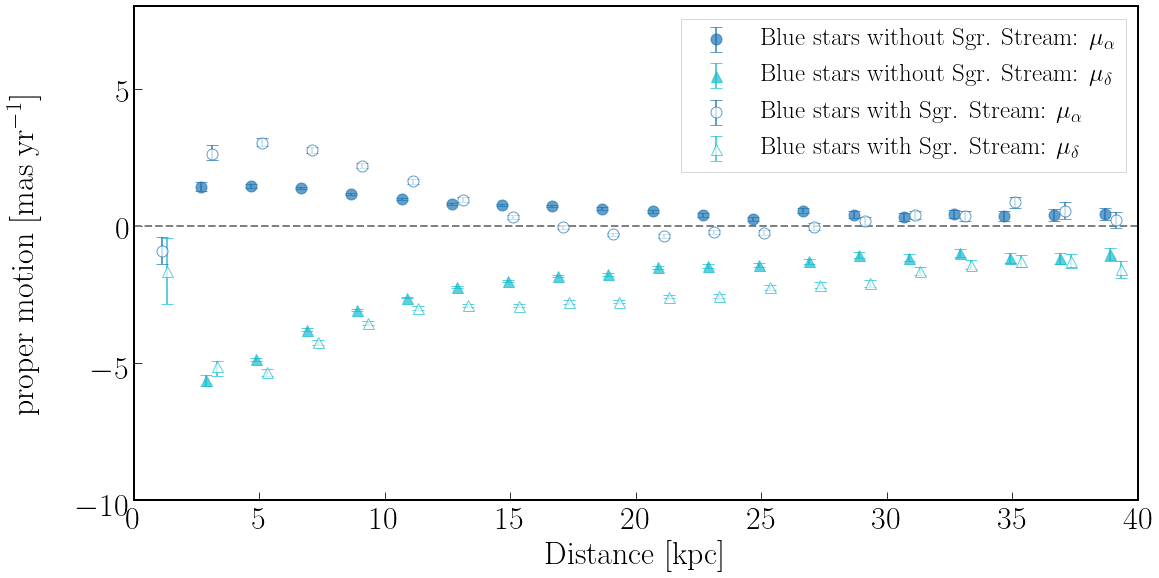

In [198]:

fig=plt.figure(figsize=(18,20))
'''ax=plt.subplot(212)
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
#ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
#ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(0,40)
ax.set_ylim(-250,200)
ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
ax.set_xlabel('Distance [kpc]',fontsize=32)
# binned medians to be more quantitative 

D = mb0.Dkpc
vra = mb0.v_ra_sm
vdec = mb0.v_dec_sm
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
ax.errorbar(x1Bin-0.3, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  c='tab:blue', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\alpha$')
ax.errorbar(x2Bin-0.1, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $v_\delta$')

D = mb1.Dkpc
vra = mb1.v_ra_sm
vdec = mb1.v_dec_sm

x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 40, 20, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 40, 20, 0)
ax.errorbar(x1Bin+0.1, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11, markerfacecolor='white', c='tab:blue', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\alpha$')
ax.errorbar(x2Bin+0.3, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $v_\delta$')





xL = np.linspace(0,200)
ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
#plt.title('velocity vs. distance for blue stars')
#    plt.legend(loc=9)'''


ax=plt.subplot(2,1,1)
#ax=fig.add_axes([0.05,0.53,0.9,0.42])
#ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
#ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(0,40)
ax.set_ylim(-10,8)
ax.set_xlabel('Distance [kpc]',fontsize=32)
ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
# binned medians to be more quantitative 
D = mb0.Dkpc
pmra = mb0.pmra_cl
pmdec = mb0.pmdec_cl
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin-0.33, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,  c='tab:blue', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\alpha$')
ax.errorbar(x2Bin-0.11, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11,  c='tab:cyan', alpha=0.7, label=r'Blue stars without Sgr. Stream: $\mu_\delta$')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 40, 100, 12, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 40, 100, 12, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 100, 150, 10, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 100, 150, 10, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8, alpha=0.7, c='tab:cyan')
D = mb1.Dkpc
pmra = mb1.pmra_cl
pmdec = mb1.pmdec_cl
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 40, 20, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 40, 20, 0)
ax.errorbar(x1Bin+0.11, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=11,markerfacecolor='white',  c='tab:blue', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\alpha$')
ax.errorbar(x2Bin+0.33, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=11, markerfacecolor='white', c='tab:cyan', alpha=0.7, label=r'Blue stars with Sgr. Stream: $\mu_\delta$')



xL = np.linspace(0,200)
ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
#plt.title('proper motion vs. distance for blue stars')
plt.legend()
#plt.savefig('../Documents/final/1/dblue_sm.pdf')
plt.savefig(pwd+'dblue_sagi.pdf')

# pm vs d FeH -1.95/-0.95 check

In [17]:

ms2=pd.read_csv('../Downloads/catalog/final/5/starall_sm.csv')
ms3=pd.read_csv('../Downloads/catalog/final/6/starall_sm.csv')

In [21]:
ms2=ms2[ms2.gr>0.2]
ms3=ms3[ms3.gr>0.2]

In [24]:
len(ms2),len(ms3)

(596217, 596217)

## -1.95

In [23]:
tt=clip(ms2,ms2.gi,ms2.gr, 0, 4, 400, 0)

In [25]:
len(tt)

555529

In [28]:
mb=tt[(tt.gr<0.6)]#&(ms.gr>0.2)]
mr=tt[(tt.gr>0.6)]#&(ms.gr<1.6)]
len(tt),len(mb),len(mr)

(555529, 97087, 458442)

In [37]:
pwd='../Documents/final/FeH-1.95/'

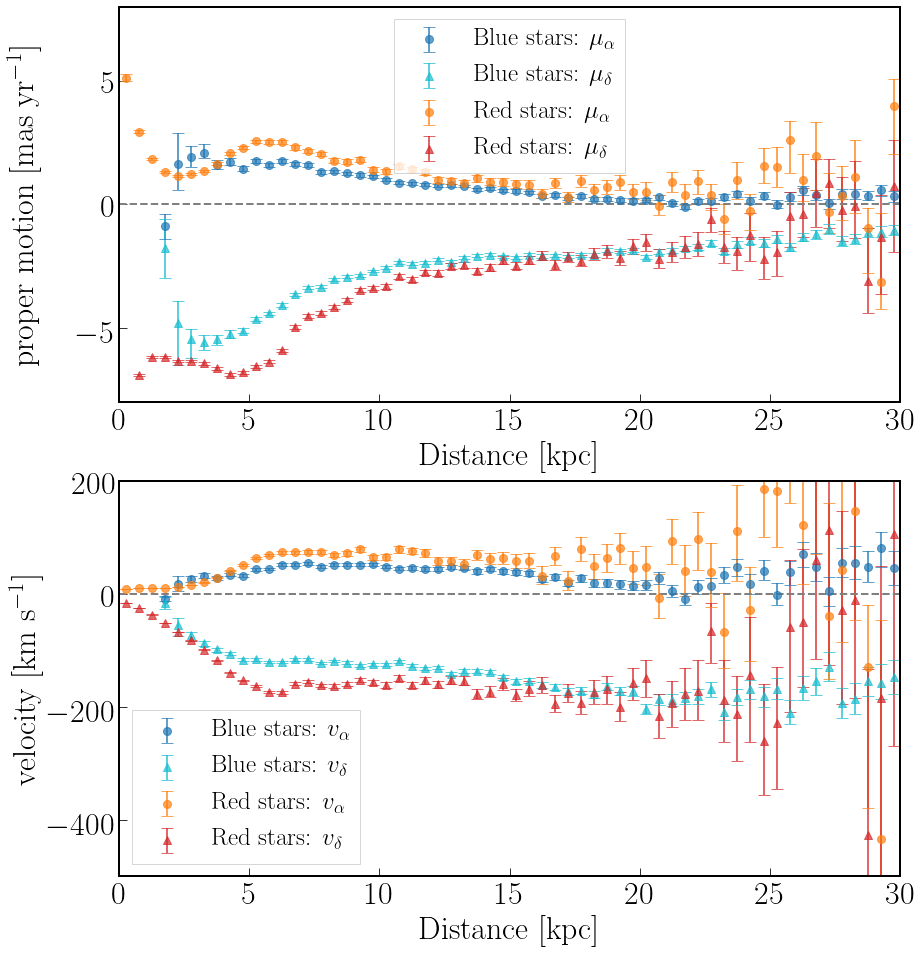

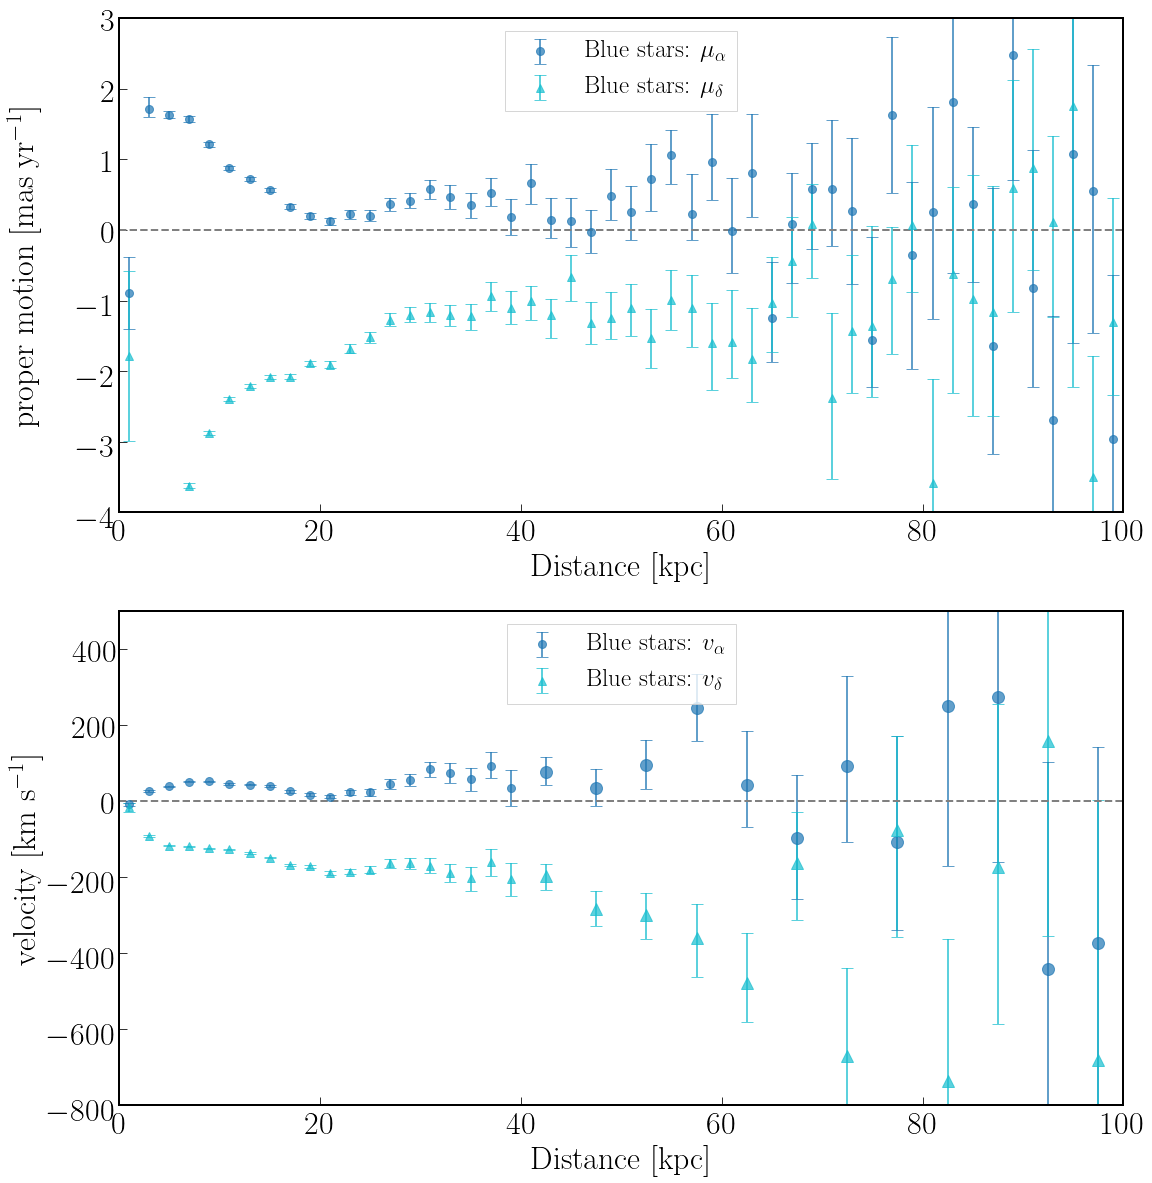

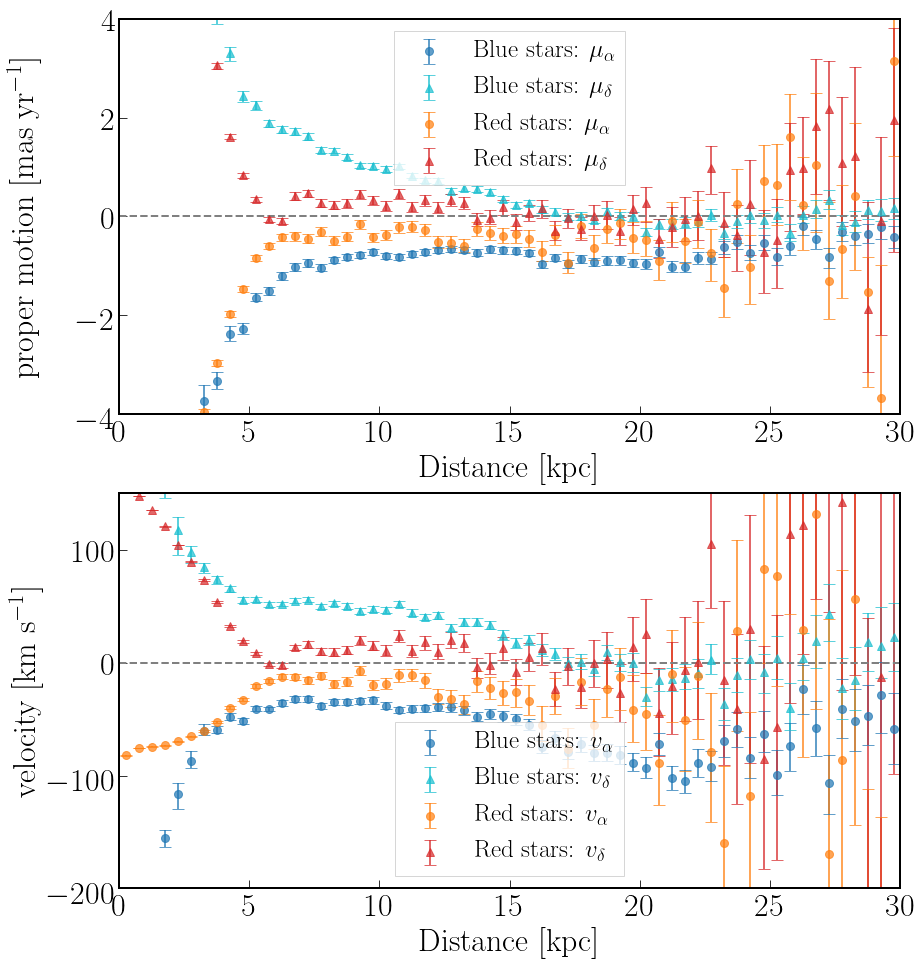

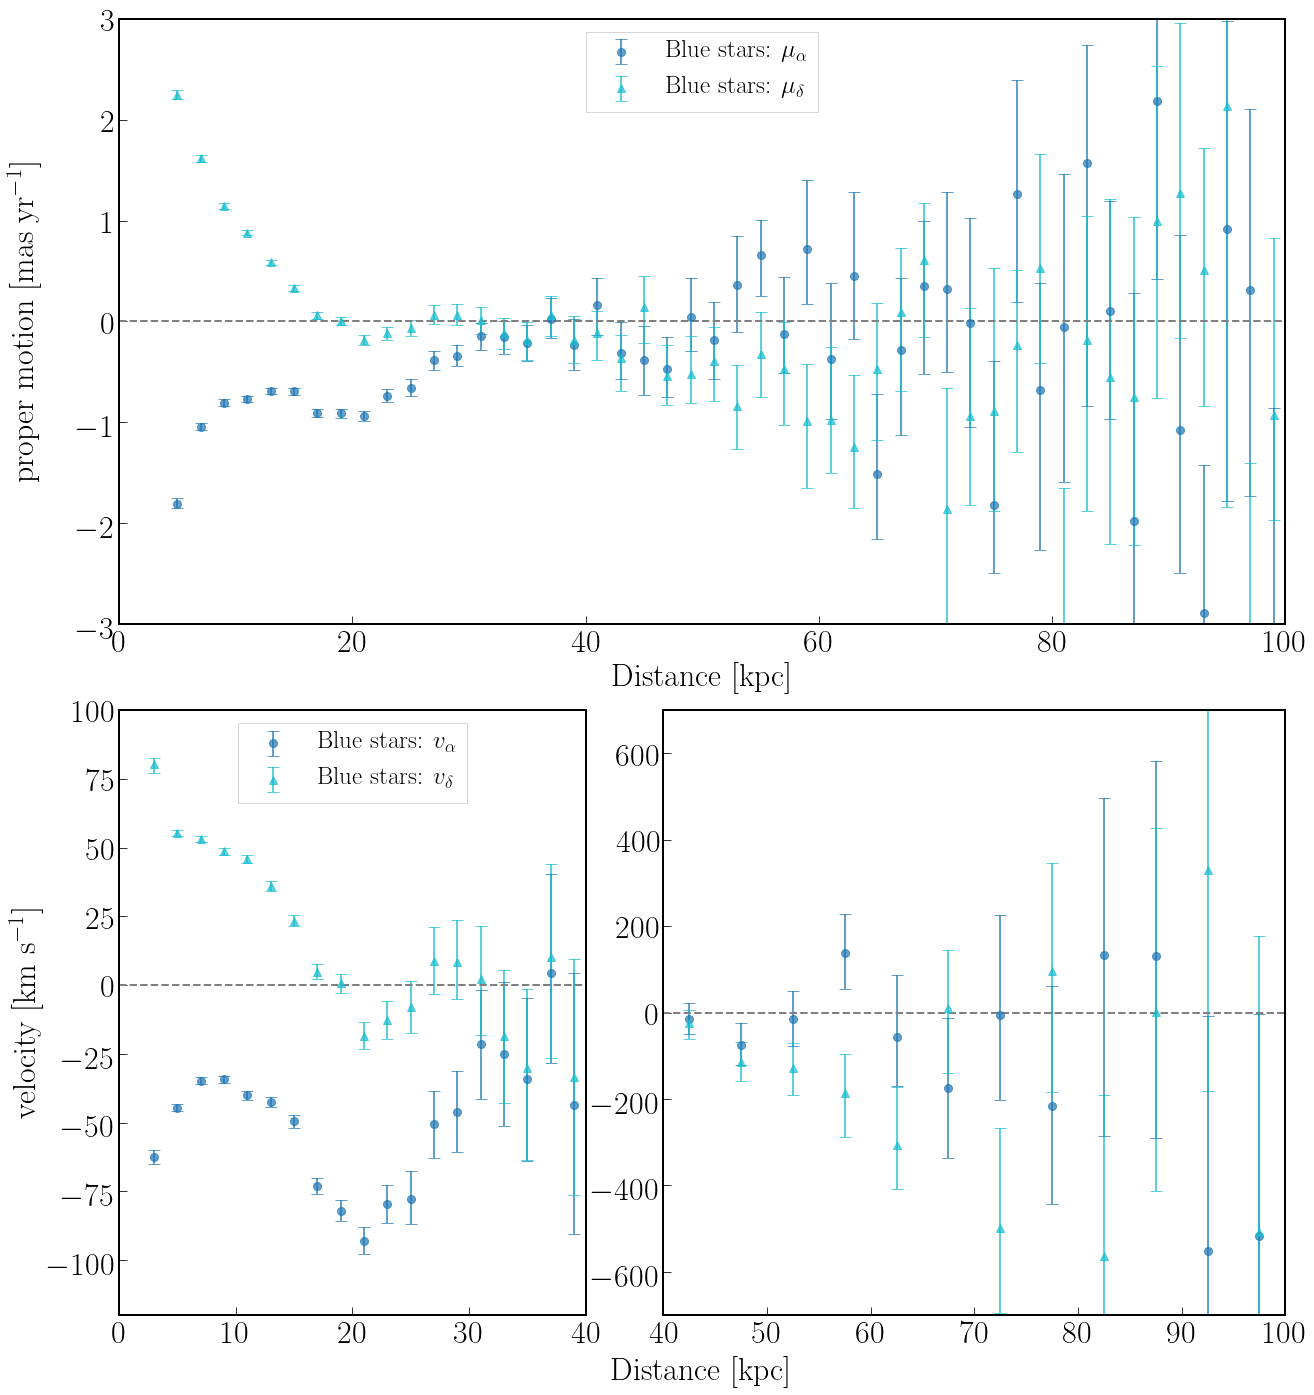

In [38]:
d_all()
dblue()
d_all_sm()
dblue_sm()

## -0.95

In [39]:
tt=clip(ms3,ms3.gi,ms3.gr, 0, 4, 400, 0)

In [40]:
len(tt)

555529

In [41]:
mb=tt[(tt.gr<0.6)]#&(ms.gr>0.2)]
mr=tt[(tt.gr>0.6)]#&(ms.gr<1.6)]
len(tt),len(mb),len(mr)

(555529, 97087, 458442)

In [42]:
pwd='../Documents/final/FeH-0.95/'

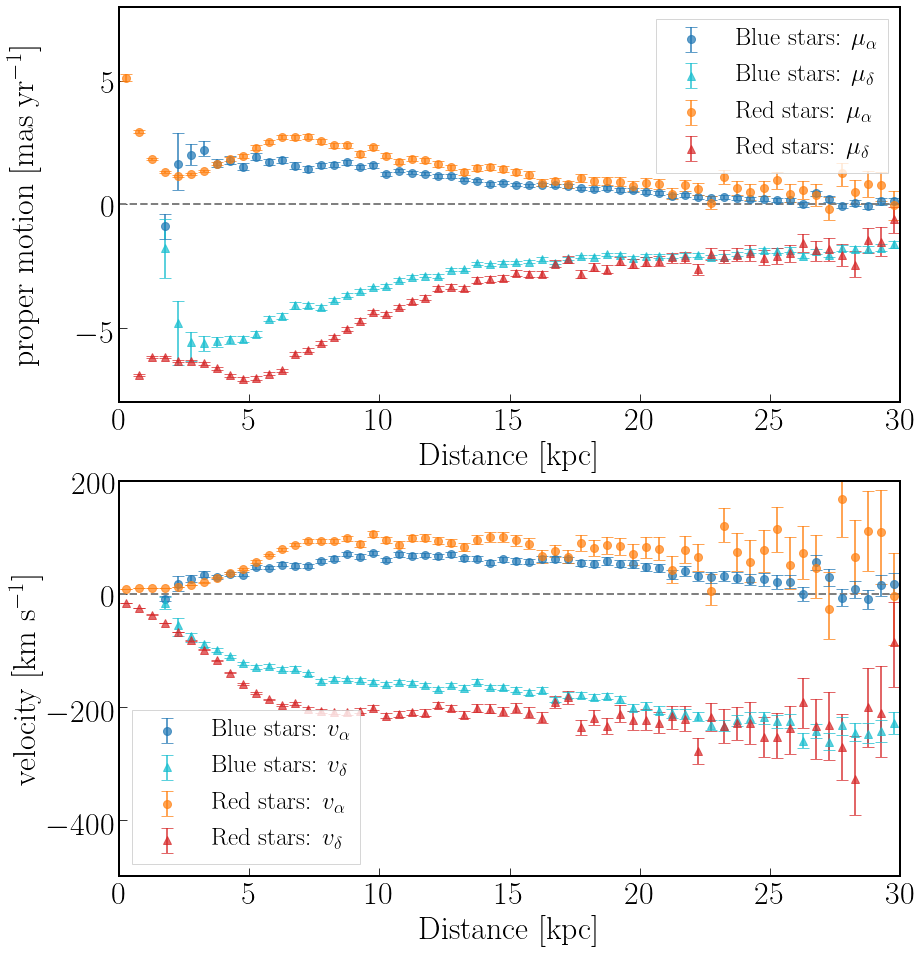

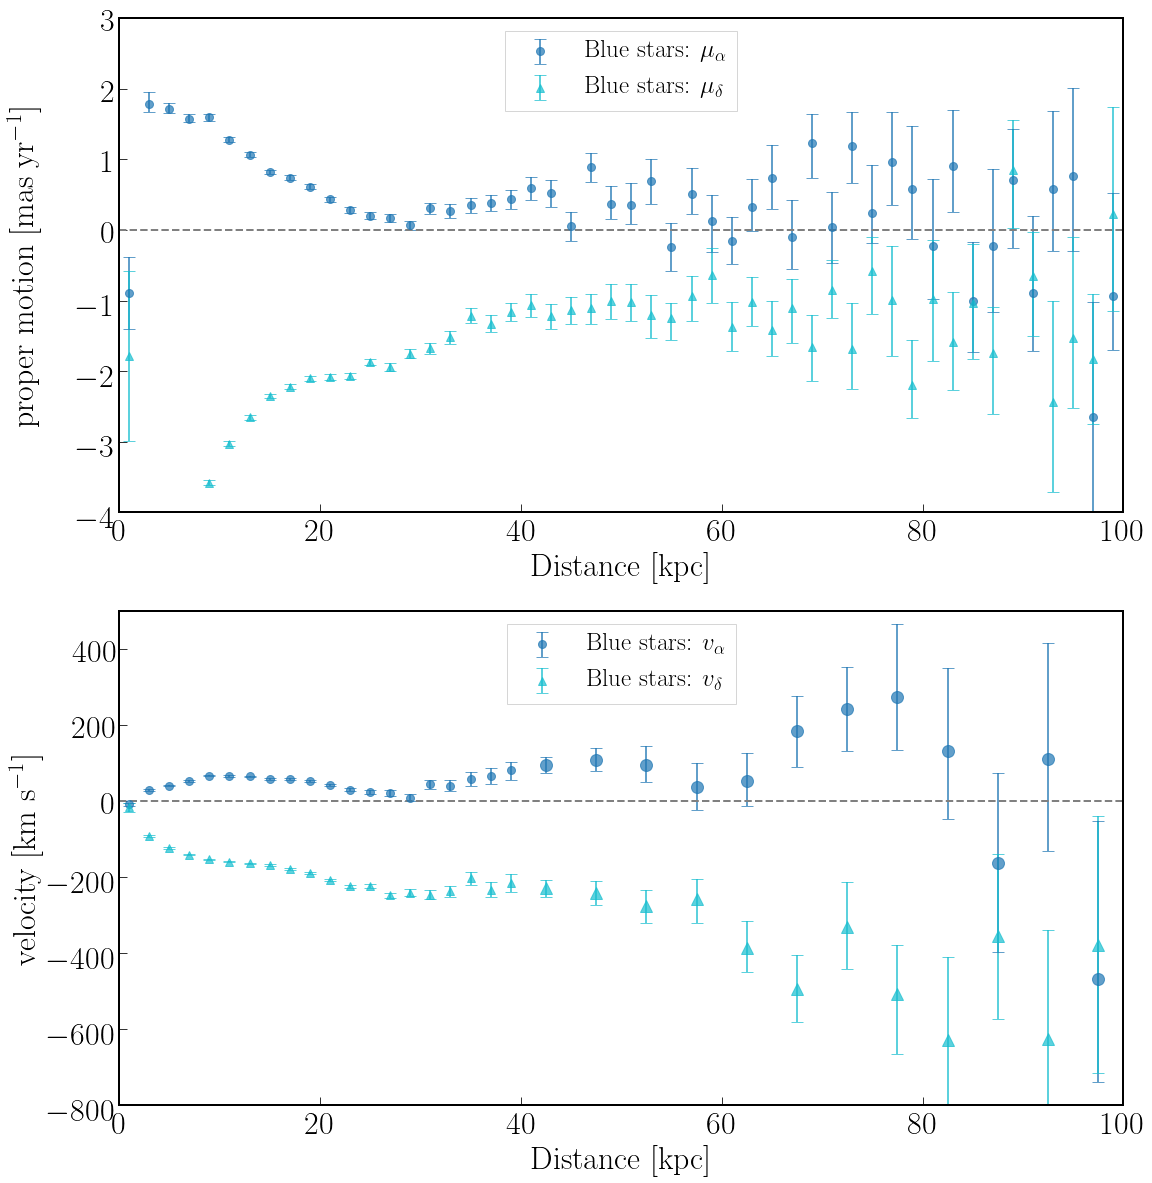

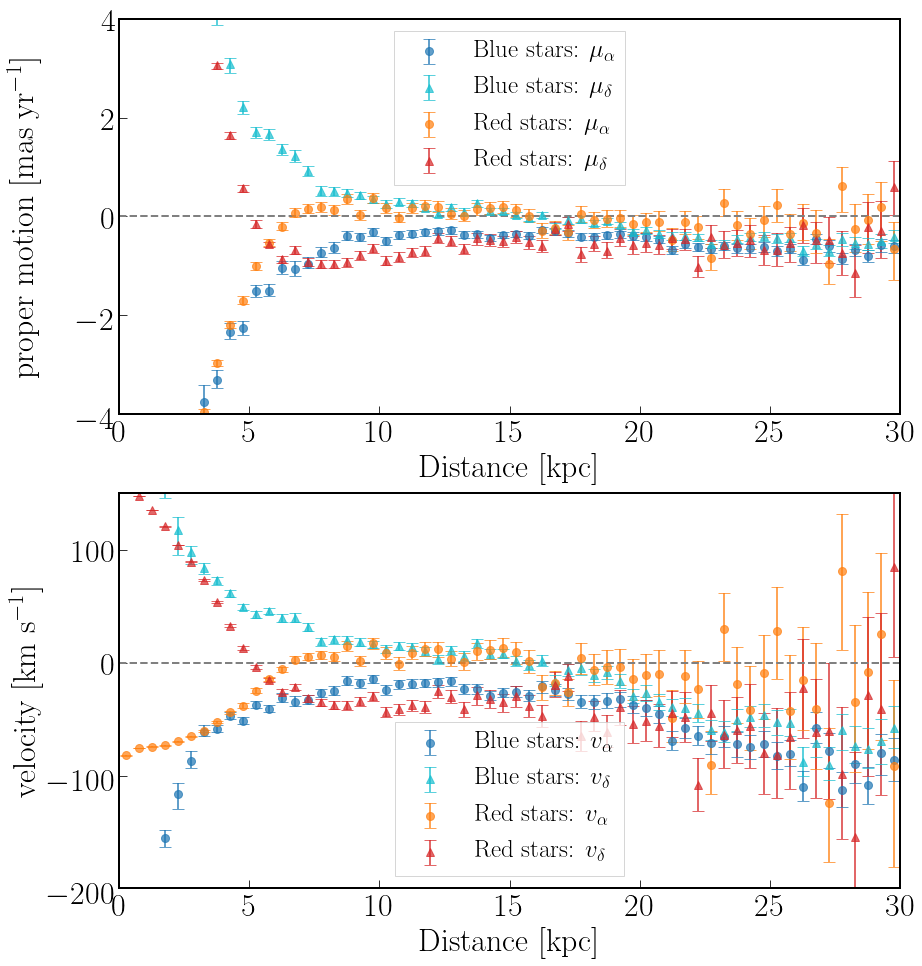

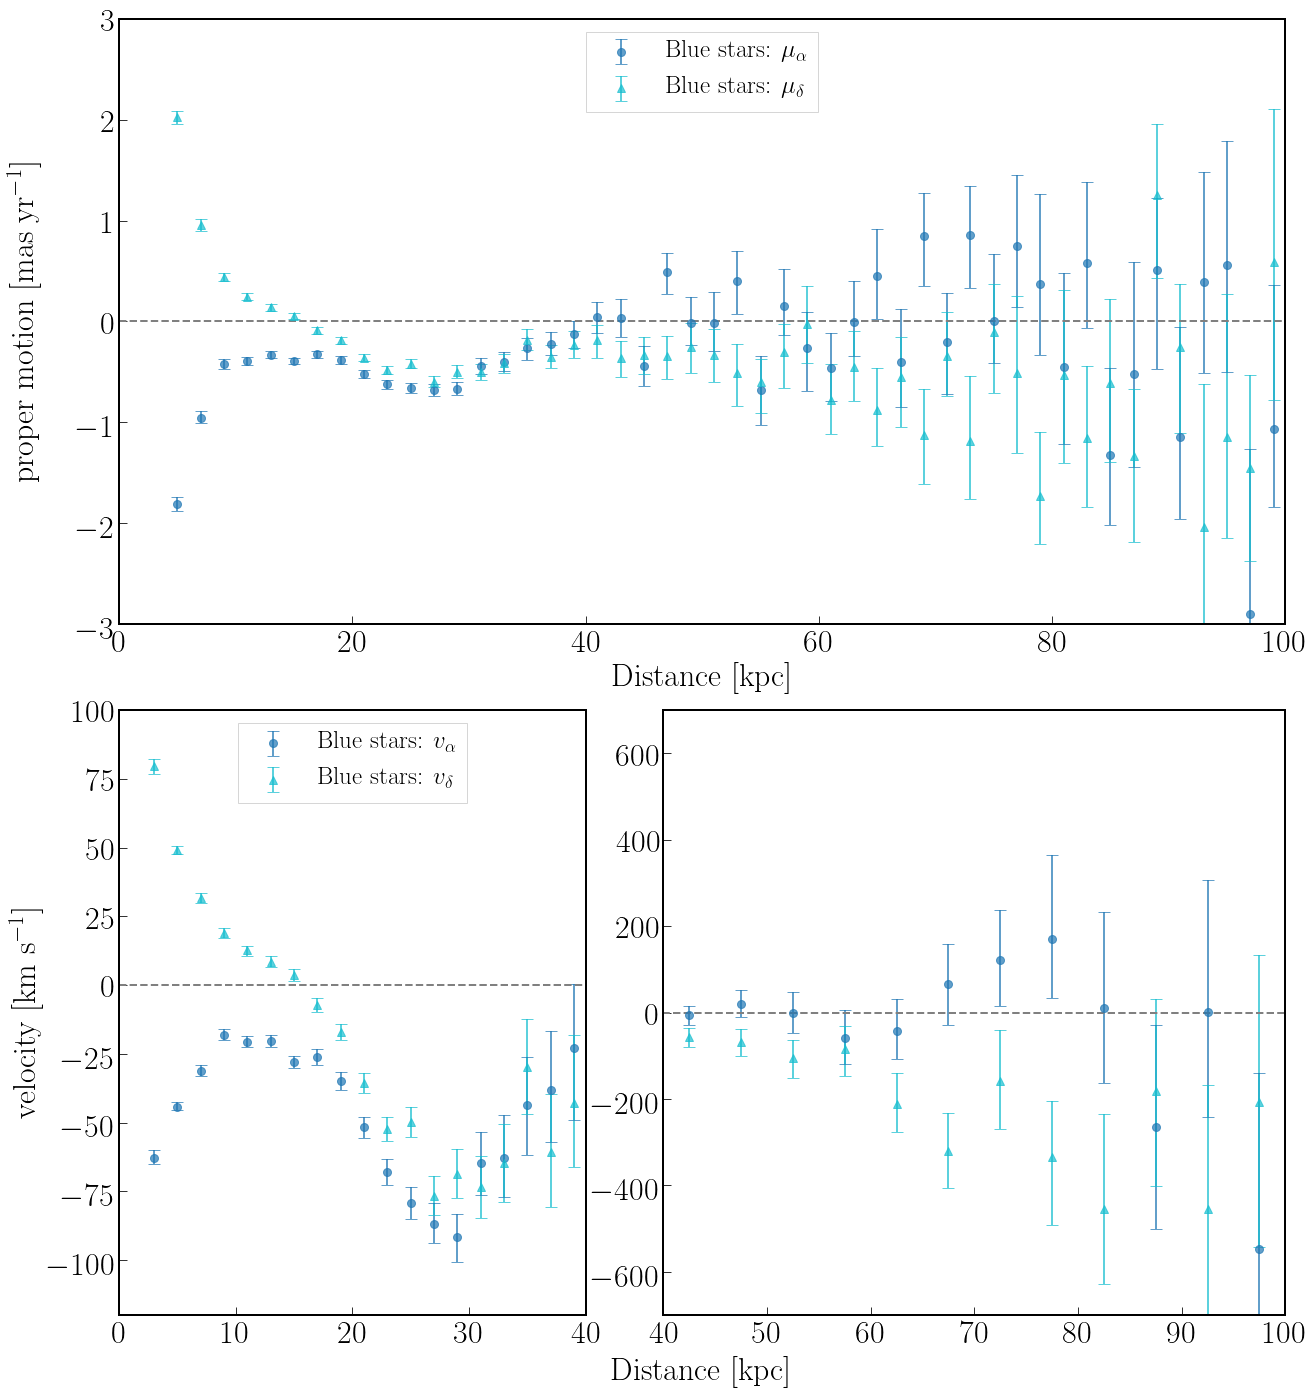

In [43]:
d_all()
dblue()
d_all_sm()
dblue_sm()

# pm vs d  Distance 20% check （old catalog)

In [16]:

ms2=pd.read_csv('../Downloads/catalog/final/check_distance/starall_sm_2.csv')
ms3=pd.read_csv('../Downloads/catalog/final/check_distance/starall_sm_3.csv')

In [37]:
ms0=pd.read_csv('../Downloads/catalog/final/starall_sm.csv')

In [27]:
mb2=ms2[ms2.gr<0.6]
mb3=ms3[ms3.gr<0.6]

In [39]:
mb0=ms0[ms0.gr<0.6]

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


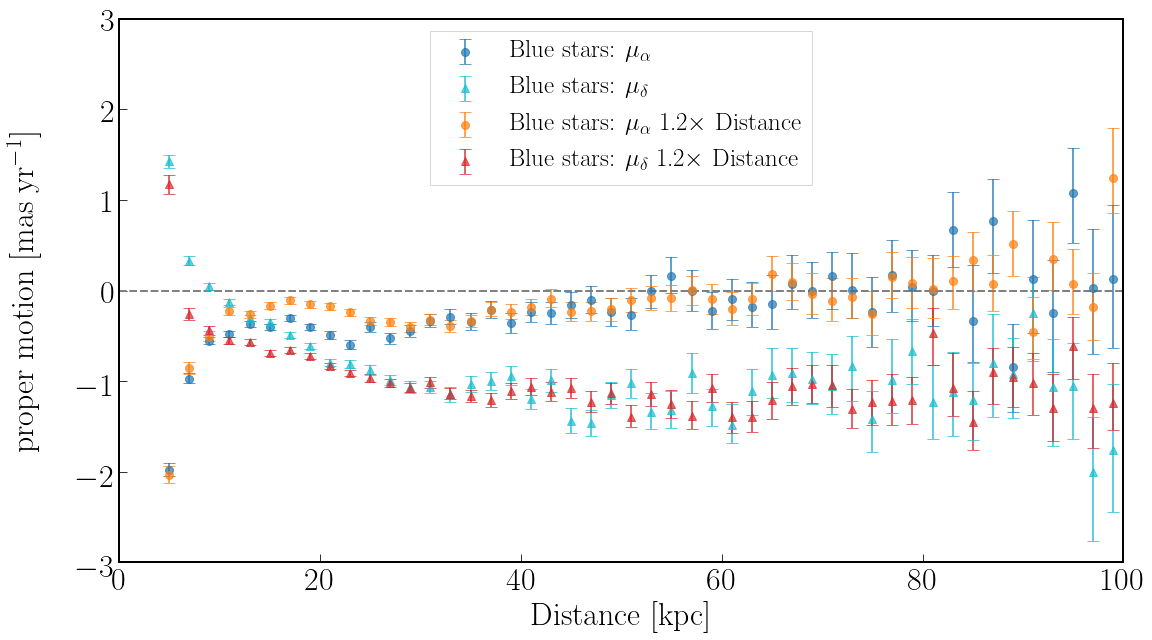

In [45]:

    r = mb0.r_psfflux_mag
    gr = mb0.gr
    D = mb0.Dkpc
#    vra = mb2.v_ra_sm
#    vdec = mb2.v_dec_sm
    pmra = mb0.pmra_cl_sm
    pmdec = mb0.pmdec_cl_sm
    fig=plt.figure(figsize=(18,10))
    ax=plt.subplot(111)
    #ax=fig.add_axes([0.05,0.53,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,100)
    ax.set_ylim(-3,3)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 100, 50, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 100, 50, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:blue', alpha=0.7, label=r'Blue stars: $\mu_\alpha$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:cyan', alpha=0.7, label=r'Blue stars: $\mu_\delta$')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 40, 100, 12, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 40, 100, 12, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 100, 150, 10, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 100, 150, 10, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8, alpha=0.7, c='tab:cyan')

    r = mb3.r_psfflux_mag
    gr = mb3.gr
    D = mb3.Dkpc*1.2
#    vra = mb2.v_ra_sm
#    vdec = mb2.v_dec_sm
    pmra = mb3.pmra_cl_sm
    pmdec = mb3.pmdec_cl_sm
    #ax=fig.add_axes([0.05,0.53,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    # binned medians to be more quantitative 
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 100, 50, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 100, 50, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:orange', alpha=0.7, label=r'Blue stars: $\mu_\alpha$ 1.2$\times$ Distance')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:red', alpha=0.7, label=r'Blue stars: $\mu_\delta$ 1.2$\times$ Distance')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 40, 100, 12, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 40, 100, 12, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 100, 150, 10, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 100, 150, 10, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8, alpha=0.7, c='tab:cyan')

    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend(loc=9)
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    #plt.savefig(pwd+'dblue_sm.pdf')
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend(loc=9)
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    #plt.savefig(pwd+'dblue_sm.pdf')
    plt.savefig(pwd+'dblue_sm1.2.pdf')

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


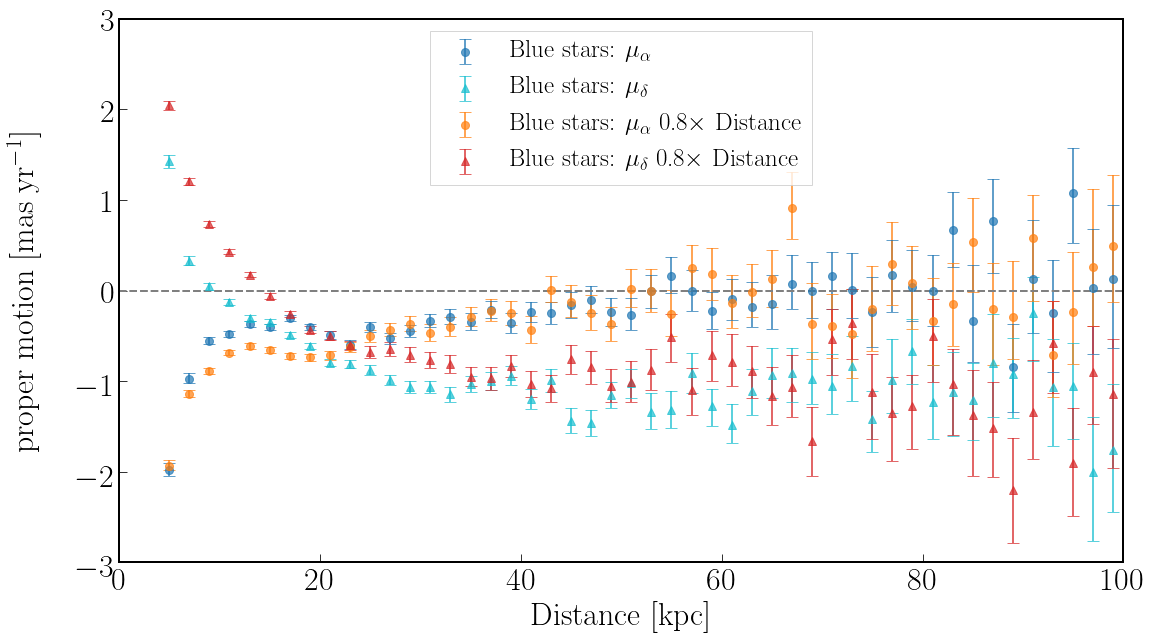

In [44]:

    r = mb0.r_psfflux_mag
    gr = mb0.gr
    D = mb0.Dkpc
#    vra = mb2.v_ra_sm
#    vdec = mb2.v_dec_sm
    pmra = mb0.pmra_cl_sm
    pmdec = mb0.pmdec_cl_sm
    fig=plt.figure(figsize=(18,10))
    ax=plt.subplot(111)
    #ax=fig.add_axes([0.05,0.53,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    ax.set_xlim(0,100)
    ax.set_ylim(-3,3)
    ax.set_xlabel('Distance [kpc]',fontsize=32)
    ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
    # binned medians to be more quantitative 
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 100, 50, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 100, 50, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:blue', alpha=0.7, label=r'Blue stars: $\mu_\alpha$')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:cyan', alpha=0.7, label=r'Blue stars: $\mu_\delta$')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 40, 100, 12, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 40, 100, 12, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 100, 150, 10, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 100, 150, 10, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8, alpha=0.7, c='tab:cyan')

    r = mb2.r_psfflux_mag
    gr = mb2.gr
    D = mb2.Dkpc*0.8
#    vra = mb2.v_ra_sm
#    vdec = mb2.v_dec_sm
    pmra = mb2.pmra_cl_sm
    pmdec = mb2.pmdec_cl_sm
    #ax=fig.add_axes([0.05,0.53,0.9,0.42])
    #ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
    #ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
    # binned medians to be more quantitative 
    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 100, 50, 0)
    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 100, 50, 0)
    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:orange', alpha=0.7, label=r'Blue stars: $\mu_\alpha$ 0.8$\times$ Distance')
    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:red', alpha=0.7, label=r'Blue stars: $\mu_\delta$ 0.8$\times$ Distance')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 40, 100, 12, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 40, 100, 12, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 100, 150, 10, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 100, 150, 10, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8, alpha=0.7, c='tab:cyan')

    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend(loc=9)
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    #plt.savefig(pwd+'dblue_sm.pdf')
    xL = np.linspace(0,200)
    ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
    #plt.title('proper motion vs. distance for blue stars')
    plt.legend(loc=9)
    #plt.savefig('../Documents/final/1/dblue_sm.pdf')
    plt.savefig(pwd+'dblue_sm0.8.pdf')

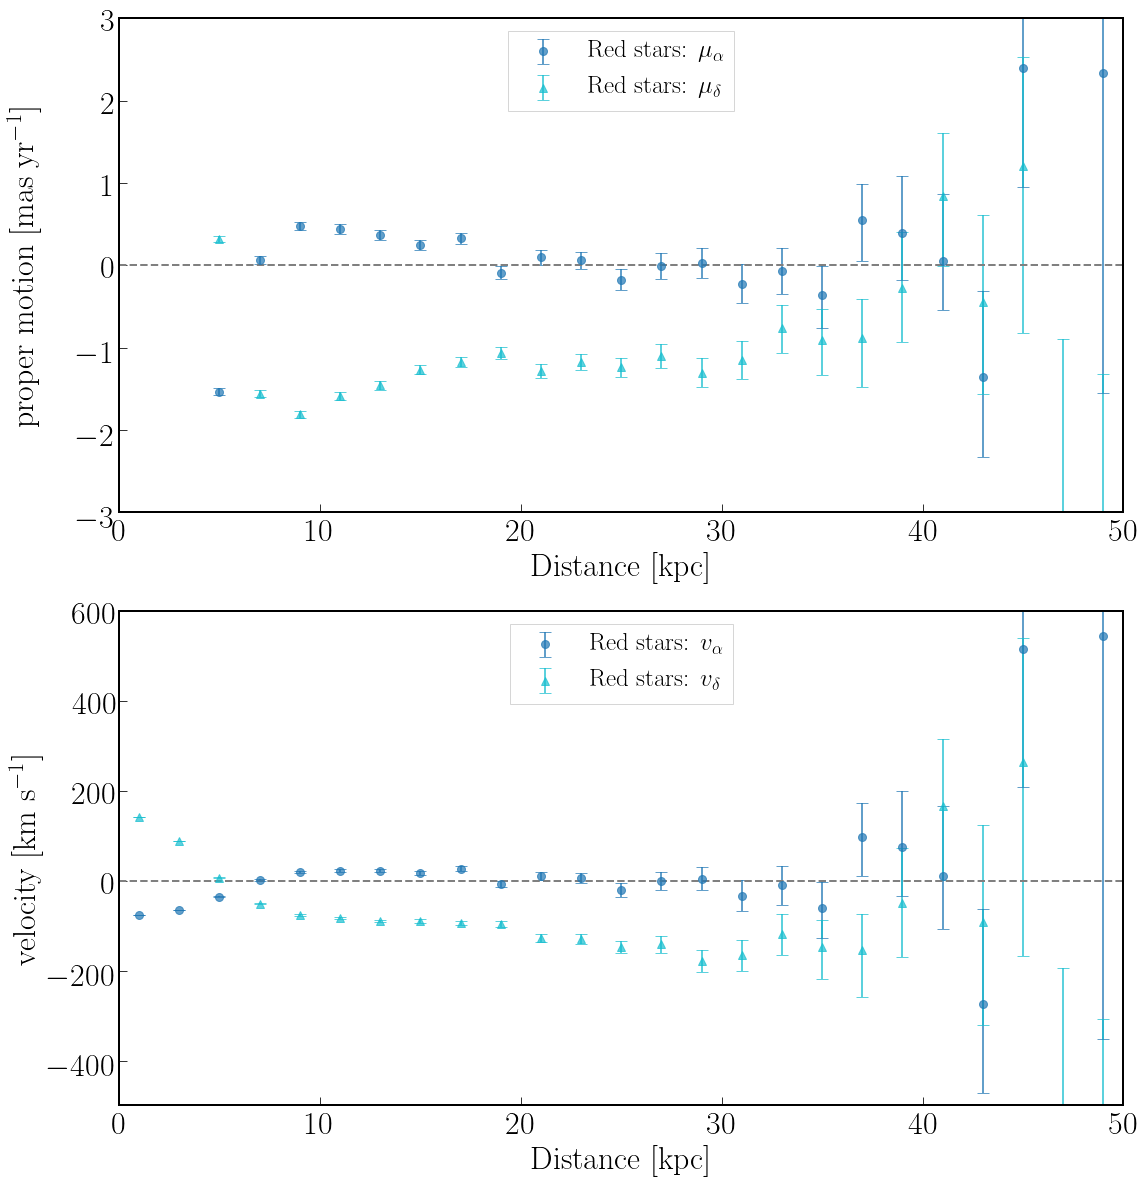

In [172]:

r = mr.r_psfflux_mag
gr = mr.gr
D = mr.Dkpc
vra = mr.v_ra_sm
vdec = mr.v_dec_sm
pmra = mr.pmra_cl_sm
pmdec = mr.pmdec_cl_sm
fig=plt.figure(figsize=(18,20))
ax=plt.subplot(212)
#    ax=fig.add_axes([0.05,0.05,0.9,0.42])
#ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
#ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(0,50)
ax.set_ylim(-500,600)
ax.set_ylabel('velocity [km s$^{-1}$]',fontsize=32)
ax.set_xlabel('Distance [kpc]',fontsize=32)
# binned medians to be more quantitative 
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 0, 50, 25, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 0, 50, 25, 0)
x3Bin=x1Bin
m3edianBin=np.sqrt(m1edianBin**2+m2edianBin**2)
s3igGbin=(abs(m1edianBin)*s1igGbin+abs(m2edianBin)*s2igGbin)/m3edianBin
ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:blue', alpha=0.7, label=r'Red stars: $v_\alpha$')
ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:cyan', alpha=0.7, label=r'Red stars: $v_\delta$')
#    ax.errorbar(x3Bin, m3edianBin, s3igGbin, fmt='*',capsize=6, markersize=8,  c='grey', alpha=0.7, label=r'Blue stars: $|v|$')
xL = np.linspace(0,200)
ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
#plt.title('velocity vs. distance for blue stars')
plt.legend(loc=9)

#ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
#ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
#ax.set_xlabel('Distance [kpc]',fontsize=32)
'''x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, vra, 40, 100, 12, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, vdec, 40, 100, 12, 0)
x3Bin=x1Bin
m3edianBin=np.sqrt(m1edianBin**2+m2edianBin**2)
s3igGbin=(abs(m1edianBin)*s1igGbin+abs(m2edianBin)*s2igGbin)/m3edianBin
ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
#   ax.errorbar(x3Bin, m3edianBin, s3igGbin, fmt='*',capsize=6, markersize=12,  c='grey', alpha=0.7, label=r'Blue stars: $|v|$')
xL = np.linspace(0,200)
ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')'''




ax=plt.subplot(2,1,1)
#ax=fig.add_axes([0.05,0.53,0.9,0.42])
#ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
#ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(0,50)
ax.set_ylim(-3,3)
ax.set_xlabel('Distance [kpc]',fontsize=32)
ax.set_ylabel('proper motion [mas yr$^{-1}$]',fontsize=32,labelpad=35)
# binned medians to be more quantitative 
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 0, 50, 25, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 0, 50, 25, 0)
ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8,  c='tab:blue', alpha=0.7, label=r'Red stars: $\mu_\alpha$')
ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8,  c='tab:cyan', alpha=0.7, label=r'Red stars: $\mu_\delta$')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 40, 100, 12, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 40, 100, 12, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=12, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=12, alpha=0.7, c='tab:cyan')
#    x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 100, 150, 10, 0)
#    x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 100, 150, 10, 0)
#    ax.errorbar(x1Bin, m1edianBin, s1igGbin, fmt='o',capsize=6, markersize=8, alpha=0.7, c='tab:blue')
#    ax.errorbar(x2Bin, m2edianBin, s2igGbin, fmt='^',capsize=6, markersize=8, alpha=0.7, c='tab:cyan')

xL = np.linspace(0,200)
ax.plot(xL, 0*xL+0.00,linestyle='dashed', c='grey')
#plt.title('proper motion vs. distance for blue stars')
plt.legend(loc=9)
#plt.savefig('../Documents/final/1/dblue_sm.pdf')
plt.savefig(pwd+'redtest.pdf')

In [95]:
msd=ms[ms.Dkpc>40]

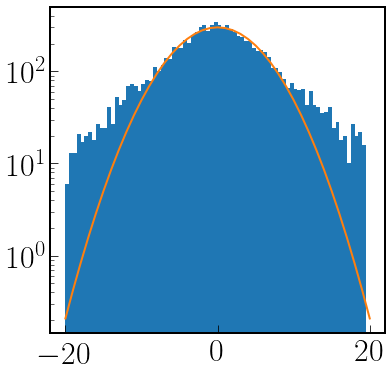

In [120]:
plt.hist(msd.pmra_cl_sm,bins=np.arange(-20,20,0.5))
x=np.arange(-20,20.1,1)
plt.plot(x,300*np.exp(-x**2/55))
plt.yscale('log')

In [203]:
min(ms[(ms.Dkpc<10)&(ms.Dkpc>9)].galcen_z)/10,max(ms[(ms.Dkpc<10)&(ms.Dkpc>9)].galcen_z)/10

(-0.8917754034644757, -0.5788623002784108)

In [206]:
np.arcsin(0.89)/np.pi*180,np.arcsin(0.57)/np.pi*180

(62.873246882726036, 34.75022575368246)

In [208]:
max(ms.b),min(ms.b)

(-39.96835245530642, -63.80848029336076)